In [2]:
def Auto_EfficentTemp_ESR_GAN(vy,vx,upscale,test_size=0.25,if_best_mode='no',modelpath=None,conv_core_num=64,cov_strides=1,cov_padding='same',conv_core_size=3,generator_deep=5,discriminator_deep=7,Vgg_deep=5,base_layer=16,simpleconv_deep=3,mbconv_deep=2,seradio=0.5,if_weight_initialize='no',weight_initialize_method='TruncatedNormal',weight_initialize_parameter1=0.00,weight_initialize_parameter2=0.05,loss_function='default',if_print_model='yes',optimizer='SGD',g_learning_rate=0.001,d_learning_rate=0.01,epochs=2000,batch_size=20,g_train_time=2,ifrandom_split='yes',ifmute='no',ifsave='no',savepath=None,device='cpu'):
    import tensorflow as tf
    if device=='gpu':
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                # 设置只使用 GPU 1
                tf.config.set_visible_devices(gpus[0], 'GPU')
                # 设置 GPU 1 的内存动态增长
                tf.config.experimental.set_memory_growth(gpus[0], True)
            except RuntimeError as e:
                print(e)
    from keras.models import Sequential,Model
    import math
    from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
    from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,Multiply,DepthwiseConv2D
    from sklearn.model_selection import train_test_split
    import numpy as np
    from tensorflow.keras.optimizers import SGD,Adam
    from scipy.stats import pearsonr
    from keras.models import load_model
    import os
    from sklearn.metrics import accuracy_score,log_loss
    
    vy=np.nan_to_num(vy,nan=0)
    vx=np.nan_to_num(vx,nan=0)
    if ifrandom_split=='yes':
        trainx,testx,trainy,testy = train_test_split(vx,vy,test_size=test_size,random_state=25)
    elif ifrandom_split=='no':
        index=int((1-test_size)*vy.shape[0])
        trainy=vy[:index,:,:,:]
        testy=vy[index:,:,:,:]
        trainx=vx[:index,:,:,:]
        testx=vx[index:,:,:,:]
    if device=='gpu':
        if optimizer == 'SGD':
            g_opt = SGD(lr = g_learning_rate)
            d_opt = SGD(lr = d_learning_rate)
        elif optimizer == 'Adam':
            g_opt = Adam(lr = g_learning_rate)
            d_opt = Adam(lr = d_learning_rate)
        if if_best_mode=='no':
            def build_generator(trainy,generator_input,generator_deep,simpleconv_deep,mbconv_deep,seradio,conv_core_num,conv_core_size,cov_strides,cov_padding,upscale,weight_initialize_parameter1,weight_initialize_parameter2):
                import tensorflow as tf
                from keras.models import Sequential,Model
                import math
                from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,Multiply,DepthwiseConv2D
                from sklearn.model_selection import train_test_split
                import numpy as np
                from tensorflow.keras.optimizers import SGD,Adam
                from scipy.stats import pearsonr
                from keras.models import load_model
                import os
                generator_inputs=Input(shape=(generator_input.shape[1],generator_input.shape[2],vx.shape[3]))
                exec('conv0=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(3,3),strides=1,padding="same")(generator_inputs)')
                exec('act0=Activation("leaky_relu")(conv0)')
                for i in range(simpleconv_deep):
                    for j in range(2+2*i):
                        if j ==0:
                            if i==0:
                                exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(act0)')
                            else:
                                exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleadd'+str(i)+')')
                        else:
                            exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j)+')')
                        exec('simpleact'+str(i+1)+'_'+str(j+1)+'=Activation("leaky_relu")(simpleconv'+str(i+1)+'_'+str(j+1)+')')
                    exec('simpleconv'+str(i+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j+1)+')')
                    exec('simpleact'+str(i+1)+'_last=Activation("leaky_relu")(simpleconv'+str(i+1)+'_last)')
                    if i==0:
                        exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,act0])')
                    else:
                        exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,simpleadd'+str(i)+'])')
                for k in range(mbconv_deep):
                    exec('mbconv'+str(k+1)+'=Conv2D('+str(base_layer*(k+1))+',(1,1),strides=1,padding="same")(simpleadd'+str(i+1)+')')
                    exec('mbact'+str(k+1)+'=Activation("leaky_relu")(mbconv'+str(k+1)+')')
                    for l in range(4+2*k):
                        if l==0:
                            exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbact'+str(k+1)+')')
                        elif l==4+2*k-1:
                            exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=4)(mbdpact'+str(k+1)+'_'+str(l)+')')
                        else:
                            exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbdpact'+str(k+1)+'_'+str(l)+')')
                        exec('mbdpact'+str(k+1)+'_'+str(l+1)+'=Activation("leaky_relu")(mbdpconv'+str(k+1)+'_'+str(l+1)+')')
                    exec('segap'+str(k+1)+'=GlobalAveragePooling2D()(mbdpact'+str(k+1)+'_'+str(l+1)+')')
                    exec('sefc'+str(k+1)+'_0=Dense('+str(int(4*base_layer*(k+1)*seradio))+')(segap'+str(k+1)+')')
                    exec('seact'+str(k+1)+'_0=Activation("leaky_relu")(sefc'+str(k+1)+'_0)')
                    exec('sefc'+str(k+1)+'_1=Dense('+str(4*base_layer*(k+1))+')(seact'+str(k+1)+'_0)')
                    exec('seact'+str(k+1)+'_1=Activation("leaky_relu")(sefc'+str(k+1)+'_1)')
                    exec('semulti'+str(k+1)+'=Multiply()([mbdpact'+str(k+1)+'_'+str(l+1)+',seact'+str(k+1)+'_1])')
                    exec('seadd'+str(k+1)+'=Add()([semulti'+str(k+1)+',mbdpact'+str(k+1)+'_'+str(l+1)+'])')
                    exec('mbconv'+str(k+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(seadd'+str(k+1)+')')
                    exec('mbact'+str(k+1)+'_last=Activation("leaky_relu")(mbconv'+str(k+1)+'_last)')
                    if k==0:
                        exec('mbconv_add'+str(k+1)+'=Add()([simpleadd'+str(i+1)+',mbact'+str(k+1)+'_last])')
                    else:
                        exec('mbconv_add'+str(k+1)+'=Add()([mbconv_add'+str(k)+',mbact'+str(k+1)+'_last])')
                exec('lastconv_0=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(mbconv_add'+str(k+1)+')')
                exec('lastact_0=Activation("leaky_relu")(lastconv_0)')
                exec('lastconv_1=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(lastact_0)')
                exec('lastact_1=Activation("leaky_relu")(lastconv_1)')
                hight=trainx.shape[1]
                weight=trainx.shape[2]
                if cov_padding=='valid':
                    hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                    weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                    if hight < 1 or weight < 1:
                        print('卷积层数过多')
                        return
                if if_weight_initialize=='no':
                    exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(lastact_1)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(lastact_1)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                for i in range(generator_deep):
                    for j in range(4):
                        if cov_padding=='valid':
                            hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                            weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                            if hight < 1 or weight < 1:
                                print('卷积层数过多')
                                break
                        if i ==0:
                            if j==0:
                                if if_weight_initialize=='no':
                                    exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_conv_start)')
                                else:
                                    if weight_initialize_method=='RandomNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_start)')
                                    elif weight_initialize_method=='RandomUniform':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv_start)')
                                    elif weight_initialize_method=='TruncatedNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_start)')
                            else:
                                if if_weight_initialize=='no':
                                    exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_concat'+str(4*i+j-1)+')')
                                else:
                                    if weight_initialize_method=='RandomNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                    elif weight_initialize_method=='RandomUniform':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                    elif weight_initialize_method=='TruncatedNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                        else:
                            if j==0:
                                if if_weight_initialize=='no':
                                    exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_conv_last'+str(4*(i-1)+3)+')')
                                else:
                                    if weight_initialize_method=='RandomNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*(i-1)+3)+')')
                                    elif weight_initialize_method=='RandomUniform':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv_last'+str(4*(i-1)+3)+')')
                                    elif weight_initialize_method=='TruncatedNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*(i-1)+3)+')')
                            else:
                                if if_weight_initialize=='no':
                                    exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_concat'+str(4*i+j-1)+')')
                                else:
                                    if weight_initialize_method=='RandomNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                    elif weight_initialize_method=='RandomUniform':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                    elif weight_initialize_method=='TruncatedNormal':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                        exec('generator_act'+str(4*i+j)+'=Activation("leaky_relu")(generator_conv'+str(4*i+j)+')')
                        for k in range(j+1):
                            if k ==0:
                                if i ==0:
                                    exec('generator_concat'+str(4*i+j)+'=Concatenate(axis=-1)([generator_conv_start,generator_act'+str(4*i+j)+'])')
                                else:
                                    exec('generator_concat'+str(4*i+j)+'=Concatenate(axis=-1)([generator_concat_last'+str(4*(i-1)+3)+',generator_act'+str(4*i+j)+'])')
                            else:
                                exec('generator_concat'+str(4*i+j)+'=Concatenate(axis=-1)([generator_concat'+str(4*i+j)+',generator_concat'+str(4*i+k-1)+'])')
                    if if_weight_initialize=='no':
                        exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same")(generator_concat'+str(4*i+j)+')')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j)+')')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_concat'+str(4*i+j)+')')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j)+')') 
                    if i ==0:
                        exec('generator_concat_last'+str(4*i+j)+'=Concatenate(axis=-1)([generator_conv_start,generator_conv_last'+str(4*i+j)+'])')
                    else:
                        exec('generator_concat_last'+str(4*i+j)+'=Concatenate(axis=-1)([generator_concat_last'+str(4*(i-1)+3)+',generator_conv_last'+str(4*i+j)+'])')
                if cov_padding=='valid':
                    hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                    weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                    if hight < 1 or weight < 1:
                        print('卷积层数过多')
                        return
                if if_weight_initialize=='no':
                    exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_conv_last'+str(4*i+j)+')')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*i+j)+')')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv_last'+str(4*i+j)+')')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*i+j)+')')
                exec('generator_concat'+str(4*i+j+1)+'=Concatenate(axis=-1)([generator_conv_start,generator_conv'+str(4*i+j+1)+'])')
                exec('generator_upsample'+str(4*i+j+1)+'=UpSampling2D(size=(upscale,upscale))(generator_concat'+str(4*i+j+1)+')')
                if cov_padding=='valid':
                    hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                    weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                    if hight < 1 or weight < 1:
                        print('卷积层数过多')
                        return
                if if_weight_initialize=='no':
                    exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_upsample'+str(4*i+j+1)+')')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample'+str(4*i+j+1)+')')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_upsample'+str(4*i+j+1)+')')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample'+str(4*i+j+1)+')')   
                if if_weight_initialize=='no':
                    generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same")(generator_conv'+str(4*i+j+2)+')')
                else:
                    if weight_initialize_method=='RandomNormal':
                        generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv'+str(4*i+j+2)+')')
                    elif weight_initialize_method=='RandomUniform':
                        generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv'+str(4*i+j+2)+')')
                    elif weight_initialize_method=='TruncatedNormal':
                        generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv'+str(4*i+j+2)+')') 
                return Model(inputs=[generator_inputs], outputs=generator_output)
            def build_discriminator(discriminator_input,discriminator_deep,conv_core_num,conv_core_size,cov_strides,cov_padding,weight_initialize_parameter1,weight_initialize_parameter2):
                import tensorflow as tf
                from keras.models import Sequential,Model
                import math
                from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,concatenate
                from sklearn.model_selection import train_test_split
                import numpy as np
                from tensorflow.keras.optimizers import SGD,Adam
                from scipy.stats import pearsonr
                from keras.models import load_model
                import os
                discriminator_inputs=Input(shape=(discriminator_input.shape[1],discriminator_input.shape[2],discriminator_input.shape[3]))
                hight=discriminator_input.shape[1]
                weight=discriminator_input.shape[2]
                if cov_padding=='valid':
                    hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                    weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                    if hight < 1 or weight < 1:
                        print('卷积层数过多')
                        return
                if if_weight_initialize=='no':
                    exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(discriminator_inputs)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_inputs)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
                exec('discriminator_act0=Activation("leaky_relu")(discriminator_conv0)')
                for i in range(discriminator_deep):
                    if cov_padding=='valid':
                        hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                        weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                        if hight < 1 or weight < 1:
                            print('卷积层数过多')
                            break
                    if i ==0:
                        if if_weight_initialize=='no':
                            exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(discriminator_act0)')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act0)')
                            elif weight_initialize_method=='RandomUniform':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act0)')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act0)')
                    else:
                        if if_weight_initialize=='no':
                            exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(discriminator_act'+str(2*i-1)+')')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(2*i-1)+')')
                            elif weight_initialize_method=='RandomUniform':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act'+str(2*i-1)+')')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(2*i-1)+')')
                    exec('discriminator_norm'+str(2*i+1)+'=BatchNormalization(axis=-1)(discriminator_conv'+str(2*i+1)+')')
                    exec('discriminator_act'+str(2*i+1)+'=Activation("leaky_relu")(discriminator_norm'+str(2*i+1)+')')
                exec('discriminator_fla'+str(2*i+1)+'=Flatten()(discriminator_act'+str(2*i+1)+')')
                exec('discriminator_fc'+str(2*i+1)+'=Dense(64)(discriminator_fla'+str(2*i+1)+')')
                exec('discriminator_act'+str(2*i+2)+'=Activation("leaky_relu")(discriminator_fc'+str(2*i+1)+')')
                discriminator_output=eval('Dense(discriminator_input.shape[3])(discriminator_act'+str(2*i+2)+')')
                return Model(inputs=[discriminator_inputs], outputs=discriminator_output)
            def build_Vgg_19(vgg_input,Vgg_deep):
                import tensorflow as tf
                from keras.models import Sequential,Model
                import math
                from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,concatenate
                from sklearn.model_selection import train_test_split
                import numpy as np
                from tensorflow.keras.optimizers import SGD,Adam
                from scipy.stats import pearsonr
                from keras.models import load_model
                import os

                vgg_inputs=Input(shape=(vgg_input.shape[1],vgg_input.shape[2],vgg_input.shape[3]))
                hight=trainx.shape[1]
                weight=trainx.shape[2]
                if Vgg_deep>=5:
                    Vgg_deeps=5
                else:
                    Vgg_deeps=Vgg_deep
                for i in range(Vgg_deeps):
                    conv_core_nums=[64,128,256,512,512]
                    if i!=0 or i!=1:
                        conv_block_len=4
                    else:
                        conv_block_len=2
                    for j in range(conv_block_len):
                        if cov_padding=='valid':
                            hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                            weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                            if hight < 1 or weight < 1:
                                print('卷积层数过多')
                                break
                        if i ==0:
                            if j==0:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_inputs)')
                            else:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                        else:
                            if j==0:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_pool'+str(i-1)+')')
                            else:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                        exec('vgg_norm'+str(i)+'=BatchNormalization(axis=-1)(vgg_conv'+str(i)+')')
                        exec('vgg_act'+str(i)+'=Activation("relu")(vgg_norm'+str(i)+')')
                    if i!=Vgg_deeps-1:
                        exec('vgg_pool'+str(i)+'=MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
                    else:
                        vgg_output=eval('MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
                return Model(inputs=[vgg_inputs], outputs=vgg_output)
            generator=build_generator(trainy,trainx,generator_deep,simpleconv_deep,mbconv_deep,seradio,conv_core_num,conv_core_size,cov_strides,cov_padding,upscale,weight_initialize_parameter1,weight_initialize_parameter2)
            generator_outputs=generator(trainx[0].reshape(1,trainx.shape[1],trainx.shape[2],trainx.shape[3]))
            discriminator=build_discriminator(generator_outputs,discriminator_deep,conv_core_num,conv_core_size,cov_strides,cov_padding,weight_initialize_parameter1,weight_initialize_parameter2)
            discriminator_outputs=discriminator(generator_outputs)
            Vgg_19=build_Vgg_19(generator_outputs,Vgg_deep)
            Vgg_outputs=Vgg_19(generator_outputs)
        else:
            generator=load_model(modelpath+'_generator',compile=False)
            discriminator=load_model(modelpath+'_discriminator',compile=False)
            Vgg_19=load_model(modelpath+'_Vgg_19',compile=False)
        def generator_loss(y_true,y_pred):
            import tensorflow as tf
            
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            y_true_mean=tf.reduce_mean(y_true,axis=0)
            y_pred_mean=tf.reduce_mean(y_pred,axis=0)
            cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
            y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
            y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
            y_true_v=tf.sqrt(y_true_v)
            y_pred_v=tf.sqrt(y_pred_v)
            pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
            result_true=discriminator(y_true)
            result_false=discriminator(y_pred)
            valid=np.ones((result_true.shape[0],result_true.shape[1]))
            vgg_false=Vgg_19(y_pred)
            vgg_true=Vgg_19(y_true)
            bc=tf.keras.losses.BinaryCrossentropy()
            bc_loss=tf.reduce_mean(bc(valid,tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
            mae=tf.keras.losses.MeanAbsoluteError()
            mae_feature_loss=tf.reduce_mean(mae(vgg_true,vgg_false))
            mae_loss=tf.reduce_mean(mae(y_true,y_pred))
            y_true_ssim=(y_true-tf.reduce_min(y_true))/(tf.reduce_max(y_true)-tf.reduce_min(y_true))
            y_pred_ssim=(y_pred-tf.reduce_min(y_pred))/(tf.reduce_max(y_pred)-tf.reduce_min(y_pred))
            ssim_loss=tf.reduce_mean(tf.image.ssim(y_pred_ssim,y_true_ssim,max_val=1.0))
            psnr_loss=tf.reduce_mean(tf.image.psnr(y_pred_ssim,y_true_ssim,max_val=1.0))
            if loss_function=='default' or loss_function=='Vgg+SSIM' or loss_function=='SSIM+Vgg':
                return (1-ssim_loss)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='Vgg':
                return mae_feature_loss+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='SSIM':
                return (1-ssim_loss)+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='Pearson':
                return (1-pearson)+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='Pearson+Vgg' or loss_function=='Vgg+Pearson':
                return (1-pearson)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='PSNR':
                return (1-psnr_loss/100.0)+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='Vgg+PSNR' or loss_function=='PSNR+Vgg':
                return (1-psnr_loss/100.0)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
        def generator_metrics(y_true,y_pred):
            import tensorflow as tf
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            y_true_mean=tf.reduce_mean(y_true,axis=0)
            y_pred_mean=tf.reduce_mean(y_pred,axis=0)
            cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
            y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
            y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
            y_true_v=tf.sqrt(y_true_v)
            y_pred_v=tf.sqrt(y_pred_v)
            pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
            return pearson
        def discriminator_loss(y_true,y_pred):
            import tensorflow as tf
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            result_true=y_pred[:int(y_pred.shape[0]/2.0)]
            result_false=y_pred[int(y_pred.shape[0]/2.0):]
            bc=tf.keras.losses.BinaryCrossentropy()
            bc_loss_false=tf.reduce_mean(bc(y_true[int(y_pred.shape[0]/2.0):],tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
            bc_loss_true=tf.reduce_mean(bc(y_true[:int(y_pred.shape[0]/2.0)],tf.sigmoid(result_true - tf.reduce_mean(result_false,axis=0))))
            return (bc_loss_false+bc_loss_true)/2.0
        generator.compile(loss=generator_loss,optimizer=g_opt,metrics=generator_metrics)
        discriminator.compile(loss=discriminator_loss,optimizer=d_opt,metrics=['accuracy'])
        if if_print_model=='yes':
            print(discriminator.summary())
            print(generator.summary())
            print(Vgg_19.summary())
        def train(epochs,trainx,trainy,generator,discriminator):
            for i in range(epochs):
                d_loss_tests=np.zeros((int(testy.shape[0]/batch_size)))
                d_acc_tests=np.zeros((int(testy.shape[0]/batch_size)))
                g_loss_tests=np.zeros((int(testy.shape[0]/batch_size)))
                g_pearson_tests=np.zeros((int(testy.shape[0]/batch_size)))
                for j in range(0, trainy.shape[0], batch_size):
                    if j+batch_size<trainy.shape[0]:
                        batch_trainx = trainx[j:j + batch_size]
                        batch_trainy = trainy[j:j + batch_size]
                        valid_train=np.ones((batch_trainx.shape[0],vy.shape[3]))
                        fake_train=np.zeros((batch_trainx.shape[0],vy.shape[3]))
                        generator_result=generator.predict(batch_trainx,verbose=0)
                        label_train=np.append(valid_train,fake_train,axis=0)
                        factor_train=np.append(batch_trainy,generator_result,axis=0)
                        d_loss_train=discriminator.train_on_batch(factor_train,label_train)
                        for l in range(g_train_time):
                            g_loss_train=generator.train_on_batch(batch_trainx,batch_trainy)
                for k in range(0,testy.shape[0],batch_size):
                    if k+batch_size<testy.shape[0]:
                        batch_testx = testx[k:k + batch_size]
                        batch_testy = testy[k:k + batch_size]
                        generator_predict=generator.predict(batch_testx,verbose=0)
                        valid_test=np.ones((batch_testx.shape[0],vy.shape[3]))
                        fake_test=np.zeros((batch_testx.shape[0],vy.shape[3]))
                        label_test=np.append(valid_test,fake_test,axis=0)
                        factor_test=np.append(batch_testy,generator_predict,axis=0)
                        d_predict=discriminator.predict(factor_test,verbose=0)
                        d_loss_tests[int(k/batch_size)]=discriminator_loss(label_test,d_predict)
                        d_acc_tests[int(k/batch_size)]=accuracy_score(label_test,np.where(tf.sigmoid(d_predict)>=0.5,1.0,0.0))
                        g_loss_tests[int(k/batch_size)]=generator_loss(batch_testy,generator_predict)
                        g_pearson_tests[int(k/batch_size)]=generator_metrics(batch_testy,generator_predict)
                d_loss_test=np.nanmean(d_loss_tests)
                d_acc_test=np.nanmean(d_acc_tests)
                g_loss_test=np.nanmean(g_loss_tests)
                g_pearson_test=np.nanmean(g_pearson_tests)
                if ifmute=='no':
                    print('第',i+1,'次训练','D loss_train:',d_loss_train[0],'D acc_train:',100*d_loss_train[1],'G loss_train:',g_loss_train[0],'G pearson_train:',g_loss_train[1])
                    print('第',i+1,'次测试','D loss_test:',np.array(d_loss_test),'D acc_test:',100*d_acc_test,'G loss_test:',np.array(g_loss_test),'G pearson_test:',np.array(g_pearson_test))
                if ifsave=='every':
                    generator.save(savepath+'_generator_'+str(i+1))
                    discriminator.save(savepath+'_discriminator_'+str(i+1))
                    Vgg_19.save(savepath+'_Vgg_19_'+str(i+1))
        train(epochs,trainx,trainy,generator,discriminator)
        predicty=np.array(generator.predict(testx)).reshape(testy.shape[0],testy.shape[1],testy.shape[2],testy.shape[3])
        r=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
        p=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
        for i in range(testy.shape[1]):
            for j in range(testy.shape[2]):
                for k in range(testy.shape[3]):
                    r[i,j,k],p[i,j,k]=pearsonr(predicty[:,i,j,k],testy[:,i,j,k])
        print('相关系数',np.nanmean(r,axis=(0,1)))
        if ifsave=='yes':
            generator.save(savepath+'_generator')
            discriminator.save(savepath+'_discriminator')
            Vgg_19.save(savepath+'_Vgg_19')
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        with tf.device('/cpu:0'):
            if optimizer == 'SGD':
                g_opt = SGD(lr = g_learning_rate)
                d_opt = SGD(lr = d_learning_rate)
            elif optimizer == 'Adam':
                g_opt = Adam(lr = g_learning_rate)
                d_opt = Adam(lr = d_learning_rate)
            if if_best_mode=='no':
                def build_generator(trainy,generator_input,generator_deep,simpleconv_deep,mbconv_deep,seradio,conv_core_num,conv_core_size,cov_strides,cov_padding,upscale,weight_initialize_parameter1,weight_initialize_parameter2):
                    import tensorflow as tf
                    from keras.models import Sequential,Model
                    import math
                    from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                    from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,Multiply,DepthwiseConv2D
                    from sklearn.model_selection import train_test_split
                    import numpy as np
                    from tensorflow.keras.optimizers import SGD,Adam
                    from scipy.stats import pearsonr
                    from keras.models import load_model
                    import os
                    generator_inputs=Input(shape=(generator_input.shape[1],generator_input.shape[2],vx.shape[3]))
                    exec('conv0=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(3,3),strides=1,padding="same")(generator_inputs)')
                    exec('act0=Activation("leaky_relu")(conv0)')
                    for i in range(simpleconv_deep):
                        for j in range(2+2*i):
                            if j ==0:
                                if i==0:
                                    exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(act0)')
                                else:
                                    exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleadd'+str(i)+')')
                            else:
                                exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j)+')')
                            exec('simpleact'+str(i+1)+'_'+str(j+1)+'=Activation("leaky_relu")(simpleconv'+str(i+1)+'_'+str(j+1)+')')
                        exec('simpleconv'+str(i+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j+1)+')')
                        exec('simpleact'+str(i+1)+'_last=Activation("leaky_relu")(simpleconv'+str(i+1)+'_last)')
                        if i==0:
                            exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,act0])')
                        else:
                            exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,simpleadd'+str(i)+'])')
                    for k in range(mbconv_deep):
                        exec('mbconv'+str(k+1)+'=Conv2D('+str(base_layer*(k+1))+',(1,1),strides=1,padding="same")(simpleadd'+str(i+1)+')')
                        exec('mbact'+str(k+1)+'=Activation("leaky_relu")(mbconv'+str(k+1)+')')
                        for l in range(4+2*k):
                            if l==0:
                                exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbact'+str(k+1)+')')
                            elif l==4+2*k-1:
                                exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=4)(mbdpact'+str(k+1)+'_'+str(l)+')')
                            else:
                                exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbdpact'+str(k+1)+'_'+str(l)+')')
                            exec('mbdpact'+str(k+1)+'_'+str(l+1)+'=Activation("leaky_relu")(mbdpconv'+str(k+1)+'_'+str(l+1)+')')
                        exec('segap'+str(k+1)+'=GlobalAveragePooling2D()(mbdpact'+str(k+1)+'_'+str(l+1)+')')
                        exec('sefc'+str(k+1)+'_0=Dense('+str(int(4*base_layer*(k+1)*seradio))+')(segap'+str(k+1)+')')
                        exec('seact'+str(k+1)+'_0=Activation("leaky_relu")(sefc'+str(k+1)+'_0)')
                        exec('sefc'+str(k+1)+'_1=Dense('+str(4*base_layer*(k+1))+')(seact'+str(k+1)+'_0)')
                        exec('seact'+str(k+1)+'_1=Activation("leaky_relu")(sefc'+str(k+1)+'_1)')
                        exec('semulti'+str(k+1)+'=Multiply()([mbdpact'+str(k+1)+'_'+str(l+1)+',seact'+str(k+1)+'_1])')
                        exec('seadd'+str(k+1)+'=Add()([semulti'+str(k+1)+',mbdpact'+str(k+1)+'_'+str(l+1)+'])')
                        exec('mbconv'+str(k+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(seadd'+str(k+1)+')')
                        exec('mbact'+str(k+1)+'_last=Activation("leaky_relu")(mbconv'+str(k+1)+'_last)')
                        if k==0:
                            exec('mbconv_add'+str(k+1)+'=Add()([simpleadd'+str(i+1)+',mbact'+str(k+1)+'_last])')
                        else:
                            exec('mbconv_add'+str(k+1)+'=Add()([mbconv_add'+str(k)+',mbact'+str(k+1)+'_last])')
                    exec('lastconv_0=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(mbconv_add'+str(k+1)+')')
                    exec('lastact_0=Activation("leaky_relu")(lastconv_0)')
                    exec('lastconv_1=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(lastact_0)')
                    exec('lastact_1=Activation("leaky_relu")(lastconv_1)')
                    hight=trainx.shape[1]
                    weight=trainx.shape[2]
                    if cov_padding=='valid':
                        hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                        weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                        if hight < 1 or weight < 1:
                            print('卷积层数过多')
                            return
                    if if_weight_initialize=='no':
                        exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(lastact_1)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(lastact_1)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv_start=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                    for i in range(generator_deep):
                        for j in range(4):
                            if cov_padding=='valid':
                                hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                                weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                                if hight < 1 or weight < 1:
                                    print('卷积层数过多')
                                    break
                            if i ==0:
                                if j==0:
                                    if if_weight_initialize=='no':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_conv_start)')
                                    else:
                                        if weight_initialize_method=='RandomNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_start)')
                                        elif weight_initialize_method=='RandomUniform':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv_start)')
                                        elif weight_initialize_method=='TruncatedNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_start)')
                                else:
                                    if if_weight_initialize=='no':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_concat'+str(4*i+j-1)+')')
                                    else:
                                        if weight_initialize_method=='RandomNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                        elif weight_initialize_method=='RandomUniform':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                        elif weight_initialize_method=='TruncatedNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                            else:
                                if j==0:
                                    if if_weight_initialize=='no':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_conv_last'+str(4*(i-1)+3)+')')
                                    else:
                                        if weight_initialize_method=='RandomNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*(i-1)+3)+')')
                                        elif weight_initialize_method=='RandomUniform':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv_last'+str(4*(i-1)+3)+')')
                                        elif weight_initialize_method=='TruncatedNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*(i-1)+3)+')')
                                else:
                                    if if_weight_initialize=='no':
                                        exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_concat'+str(4*i+j-1)+')')
                                    else:
                                        if weight_initialize_method=='RandomNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                        elif weight_initialize_method=='RandomUniform':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                                        elif weight_initialize_method=='TruncatedNormal':
                                            exec('generator_conv'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j-1)+')')
                            exec('generator_act'+str(4*i+j)+'=Activation("leaky_relu")(generator_conv'+str(4*i+j)+')')
                            for k in range(j+1):
                                if k ==0:
                                    if i ==0:
                                        exec('generator_concat'+str(4*i+j)+'=Concatenate(axis=-1)([generator_conv_start,generator_act'+str(4*i+j)+'])')
                                    else:
                                        exec('generator_concat'+str(4*i+j)+'=Concatenate(axis=-1)([generator_concat_last'+str(4*(i-1)+3)+',generator_act'+str(4*i+j)+'])')
                                else:
                                    exec('generator_concat'+str(4*i+j)+'=Concatenate(axis=-1)([generator_concat'+str(4*i+j)+',generator_concat'+str(4*i+k-1)+'])')
                        if if_weight_initialize=='no':
                            exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same")(generator_concat'+str(4*i+j)+')')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j)+')')
                            elif weight_initialize_method=='RandomUniform':
                                exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_concat'+str(4*i+j)+')')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('generator_conv_last'+str(4*i+j)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_concat'+str(4*i+j)+')') 
                        if i ==0:
                            exec('generator_concat_last'+str(4*i+j)+'=Concatenate(axis=-1)([generator_conv_start,generator_conv_last'+str(4*i+j)+'])')
                        else:
                            exec('generator_concat_last'+str(4*i+j)+'=Concatenate(axis=-1)([generator_concat_last'+str(4*(i-1)+3)+',generator_conv_last'+str(4*i+j)+'])')
                    if cov_padding=='valid':
                        hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                        weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                        if hight < 1 or weight < 1:
                            print('卷积层数过多')
                            return
                    if if_weight_initialize=='no':
                        exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_conv_last'+str(4*i+j)+')')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*i+j)+')')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv_last'+str(4*i+j)+')')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv'+str(4*i+j+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv_last'+str(4*i+j)+')')
                    exec('generator_concat'+str(4*i+j+1)+'=Concatenate(axis=-1)([generator_conv_start,generator_conv'+str(4*i+j+1)+'])')
                    exec('generator_upsample'+str(4*i+j+1)+'=UpSampling2D(size=(upscale,upscale))(generator_concat'+str(4*i+j+1)+')')
                    if cov_padding=='valid':
                        hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                        weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                        if hight < 1 or weight < 1:
                            print('卷积层数过多')
                            return
                    if if_weight_initialize=='no':
                        exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(generator_upsample'+str(4*i+j+1)+')')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample'+str(4*i+j+1)+')')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_upsample'+str(4*i+j+1)+')')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv'+str(4*i+j+2)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample'+str(4*i+j+1)+')')   
                    if if_weight_initialize=='no':
                        generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same")(generator_conv'+str(4*i+j+2)+')')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv'+str(4*i+j+2)+')')
                        elif weight_initialize_method=='RandomUniform':
                            generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_conv'+str(4*i+j+2)+')')
                        elif weight_initialize_method=='TruncatedNormal':
                            generator_output=eval('Conv2D(int(trainy.shape[3]),(1,1),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_conv'+str(4*i+j+2)+')') 
                    return Model(inputs=[generator_inputs], outputs=generator_output)
                def build_discriminator(discriminator_input,discriminator_deep,conv_core_num,conv_core_size,cov_strides,cov_padding,weight_initialize_parameter1,weight_initialize_parameter2):
                    import tensorflow as tf
                    from keras.models import Sequential,Model
                    import math
                    from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                    from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,concatenate
                    from sklearn.model_selection import train_test_split
                    import numpy as np
                    from tensorflow.keras.optimizers import SGD,Adam
                    from scipy.stats import pearsonr
                    from keras.models import load_model
                    import os
                    discriminator_inputs=Input(shape=(discriminator_input.shape[1],discriminator_input.shape[2],discriminator_input.shape[3]))
                    hight=discriminator_input.shape[1]
                    weight=discriminator_input.shape[2]
                    if cov_padding=='valid':
                        hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                        weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                        if hight < 1 or weight < 1:
                            print('卷积层数过多')
                            return
                    if if_weight_initialize=='no':
                        exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(discriminator_inputs)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_inputs)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('discriminator_conv0=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
                    exec('discriminator_act0=Activation("leaky_relu")(discriminator_conv0)')
                    for i in range(discriminator_deep):
                        if cov_padding=='valid':
                            hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                            weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                            if hight < 1 or weight < 1:
                                print('卷积层数过多')
                                break
                        if i ==0:
                            if if_weight_initialize=='no':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(discriminator_act0)')
                            else:
                                if weight_initialize_method=='RandomNormal':
                                    exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act0)')
                                elif weight_initialize_method=='RandomUniform':
                                    exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act0)')
                                elif weight_initialize_method=='TruncatedNormal':
                                    exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act0)')
                        else:
                            if if_weight_initialize=='no':
                                exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding)(discriminator_act'+str(2*i-1)+')')
                            else:
                                if weight_initialize_method=='RandomNormal':
                                    exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(2*i-1)+')')
                                elif weight_initialize_method=='RandomUniform':
                                    exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act'+str(2*i-1)+')')
                                elif weight_initialize_method=='TruncatedNormal':
                                    exec('discriminator_conv'+str(2*i+1)+'=Conv2D(conv_core_num,(conv_core_size,conv_core_size),strides=cov_strides,padding=cov_padding,kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(2*i-1)+')')
                        exec('discriminator_norm'+str(2*i+1)+'=BatchNormalization(axis=-1)(discriminator_conv'+str(2*i+1)+')')
                        exec('discriminator_act'+str(2*i+1)+'=Activation("leaky_relu")(discriminator_norm'+str(2*i+1)+')')
                    exec('discriminator_fla'+str(2*i+1)+'=Flatten()(discriminator_act'+str(2*i+1)+')')
                    exec('discriminator_fc'+str(2*i+1)+'=Dense(64)(discriminator_fla'+str(2*i+1)+')')
                    exec('discriminator_act'+str(2*i+2)+'=Activation("leaky_relu")(discriminator_fc'+str(2*i+1)+')')
                    discriminator_output=eval('Dense(discriminator_input.shape[3])(discriminator_act'+str(2*i+2)+')')
                    return Model(inputs=[discriminator_inputs], outputs=discriminator_output)
                def build_Vgg_19(vgg_input,Vgg_deep):
                    import tensorflow as tf
                    from keras.models import Sequential,Model
                    import math
                    from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                    from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,concatenate
                    from sklearn.model_selection import train_test_split
                    import numpy as np
                    from tensorflow.keras.optimizers import SGD,Adam
                    from scipy.stats import pearsonr
                    from keras.models import load_model
                    import os

                    vgg_inputs=Input(shape=(vgg_input.shape[1],vgg_input.shape[2],vgg_input.shape[3]))
                    hight=trainx.shape[1]
                    weight=trainx.shape[2]
                    if Vgg_deep>=5:
                        Vgg_deeps=5
                    else:
                        Vgg_deeps=Vgg_deep
                    for i in range(Vgg_deeps):
                        conv_core_nums=[64,128,256,512,512]
                        if i!=0 or i!=1:
                            conv_block_len=4
                        else:
                            conv_block_len=2
                        for j in range(conv_block_len):
                            if cov_padding=='valid':
                                hight=math.ceil(1+((hight-conv_core_size)/cov_strides))
                                weight=math.ceil(1+((weight-conv_core_size)/cov_strides))
                                if hight < 1 or weight < 1:
                                    print('卷积层数过多')
                                    break
                            if i ==0:
                                if j==0:
                                    exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_inputs)')
                                else:
                                    exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                            else:
                                if j==0:
                                    exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_pool'+str(i-1)+')')
                                else:
                                    exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                            exec('vgg_norm'+str(i)+'=BatchNormalization(axis=-1)(vgg_conv'+str(i)+')')
                            exec('vgg_act'+str(i)+'=Activation("relu")(vgg_norm'+str(i)+')')
                        if i!=Vgg_deeps-1:
                            exec('vgg_pool'+str(i)+'=MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
                        else:
                            vgg_output=eval('MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
                    return Model(inputs=[vgg_inputs], outputs=vgg_output)
                generator=build_generator(trainy,trainx,generator_deep,simpleconv_deep,mbconv_deep,seradio,conv_core_num,conv_core_size,cov_strides,cov_padding,upscale,weight_initialize_parameter1,weight_initialize_parameter2)
                generator_outputs=generator(trainx[0].reshape(1,trainx.shape[1],trainx.shape[2],trainx.shape[3]))
                discriminator=build_discriminator(generator_outputs,discriminator_deep,conv_core_num,conv_core_size,cov_strides,cov_padding,weight_initialize_parameter1,weight_initialize_parameter2)
                discriminator_outputs=discriminator(generator_outputs)
                Vgg_19=build_Vgg_19(generator_outputs,Vgg_deep)
                Vgg_outputs=Vgg_19(generator_outputs)
            else:
                generator=load_model(modelpath+'_generator',compile=False)
                discriminator=load_model(modelpath+'_discriminator',compile=False)
                Vgg_19=load_model(modelpath+'_Vgg_19',compile=False)
            def generator_loss(y_true,y_pred):
                import tensorflow as tf

                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                y_true_mean=tf.reduce_mean(y_true,axis=0)
                y_pred_mean=tf.reduce_mean(y_pred,axis=0)
                cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
                y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
                y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
                y_true_v=tf.sqrt(y_true_v)
                y_pred_v=tf.sqrt(y_pred_v)
                pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
                result_true=discriminator(y_true)
                result_false=discriminator(y_pred)
                valid=np.ones((result_true.shape[0],result_true.shape[1]))
                vgg_false=Vgg_19(y_pred)
                vgg_true=Vgg_19(y_true)
                bc=tf.keras.losses.BinaryCrossentropy()
                bc_loss=tf.reduce_mean(bc(valid,tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
                mae=tf.keras.losses.MeanAbsoluteError()
                mae_feature_loss=tf.reduce_mean(mae(vgg_true,vgg_false))
                mae_loss=tf.reduce_mean(mae(y_true,y_pred))
                y_true_ssim=(y_true-tf.reduce_min(y_true))/(tf.reduce_max(y_true)-tf.reduce_min(y_true))
                y_pred_ssim=(y_pred-tf.reduce_min(y_pred))/(tf.reduce_max(y_pred)-tf.reduce_min(y_pred))
                ssim_loss=tf.reduce_mean(tf.image.ssim(y_pred_ssim,y_true_ssim,max_val=1.0))
                psnr_loss=tf.reduce_mean(tf.image.psnr(y_pred_ssim,y_true_ssim,max_val=1.0))
                if loss_function=='default' or loss_function=='Vgg+SSIM' or loss_function=='SSIM+Vgg':
                    return (1-ssim_loss)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='Vgg':
                    return mae_feature_loss+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='SSIM':
                    return (1-ssim_loss)+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='Pearson':
                    return (1-pearson)+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='Pearson+Vgg' or loss_function=='Vgg+Pearson':
                    return (1-pearson)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='PSNR':
                    return (1-psnr_loss/100.0)+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='Vgg+PSNR' or loss_function=='PSNR+Vgg':
                    return (1-psnr_loss/100.0)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
            def generator_metrics(y_true,y_pred):
                import tensorflow as tf
                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                y_true_mean=tf.reduce_mean(y_true,axis=0)
                y_pred_mean=tf.reduce_mean(y_pred,axis=0)
                cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
                y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
                y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
                y_true_v=tf.sqrt(y_true_v)
                y_pred_v=tf.sqrt(y_pred_v)
                pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
                return pearson
            def discriminator_loss(y_true,y_pred):
                import tensorflow as tf
                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                result_true=y_pred[:int(y_pred.shape[0]/2.0)]
                result_false=y_pred[int(y_pred.shape[0]/2.0):]
                bc=tf.keras.losses.BinaryCrossentropy()
                bc_loss_false=tf.reduce_mean(bc(y_true[int(y_pred.shape[0]/2.0):],tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
                bc_loss_true=tf.reduce_mean(bc(y_true[:int(y_pred.shape[0]/2.0)],tf.sigmoid(result_true - tf.reduce_mean(result_false,axis=0))))
                return (bc_loss_false+bc_loss_true)/2.0
            generator.compile(loss=generator_loss,optimizer=g_opt,metrics=generator_metrics)
            discriminator.compile(loss=discriminator_loss,optimizer=d_opt,metrics=['accuracy'])
            if if_print_model=='yes':
                print(discriminator.summary())
                print(generator.summary())
                print(Vgg_19.summary())
            def train(epochs,trainx,trainy,generator,discriminator):
                for i in range(epochs):
                    d_loss_tests=np.zeros((int(testy.shape[0]/batch_size)))
                    d_acc_tests=np.zeros((int(testy.shape[0]/batch_size)))
                    g_loss_tests=np.zeros((int(testy.shape[0]/batch_size)))
                    g_pearson_tests=np.zeros((int(testy.shape[0]/batch_size)))
                    for j in range(0, trainy.shape[0], batch_size):
                        if j+batch_size<trainy.shape[0]:
                            batch_trainx = trainx[j:j + batch_size]
                            batch_trainy = trainy[j:j + batch_size]
                            valid_train=np.ones((batch_trainx.shape[0],vy.shape[3]))
                            fake_train=np.zeros((batch_trainx.shape[0],vy.shape[3]))
                            generator_result=generator.predict(batch_trainx,verbose=0)
                            label_train=np.append(valid_train,fake_train,axis=0)
                            factor_train=np.append(batch_trainy,generator_result,axis=0)
                            d_loss_train=discriminator.train_on_batch(factor_train,label_train)
                            for l in range(g_train_time):
                                g_loss_train=generator.train_on_batch(batch_trainx,batch_trainy)
                    for k in range(0,testy.shape[0],batch_size):
                        if k+batch_size<testy.shape[0]:
                            batch_testx = testx[k:k + batch_size]
                            batch_testy = testy[k:k + batch_size]
                            generator_predict=generator.predict(batch_testx,verbose=0)
                            valid_test=np.ones((batch_testx.shape[0],vy.shape[3]))
                            fake_test=np.zeros((batch_testx.shape[0],vy.shape[3]))
                            label_test=np.append(valid_test,fake_test,axis=0)
                            factor_test=np.append(batch_testy,generator_predict,axis=0)
                            d_predict=discriminator.predict(factor_test,verbose=0)
                            d_loss_tests[int(k/batch_size)]=discriminator_loss(label_test,d_predict)
                            d_acc_tests[int(k/batch_size)]=accuracy_score(label_test,np.where(tf.sigmoid(d_predict)>=0.5,1.0,0.0))
                            g_loss_tests[int(k/batch_size)]=generator_loss(batch_testy,generator_predict)
                            g_pearson_tests[int(k/batch_size)]=generator_metrics(batch_testy,generator_predict)
                    d_loss_test=np.nanmean(d_loss_tests)
                    d_acc_test=np.nanmean(d_acc_tests)
                    g_loss_test=np.nanmean(g_loss_tests)
                    g_pearson_test=np.nanmean(g_pearson_tests)
                    if ifmute=='no':
                        print('第',i+1,'次训练','D loss_train:',d_loss_train[0],'D acc_train:',100*d_loss_train[1],'G loss_train:',g_loss_train[0],'G pearson_train:',g_loss_train[1])
                        print('第',i+1,'次测试','D loss_test:',np.array(d_loss_test),'D acc_test:',100*d_acc_test,'G loss_test:',np.array(g_loss_test),'G pearson_test:',np.array(g_pearson_test))
                    if ifsave=='every':
                        generator.save(savepath+'_generator_'+str(i+1))
                        discriminator.save(savepath+'_discriminator_'+str(i+1))
                        Vgg_19.save(savepath+'_Vgg_19_'+str(i+1))
            train(epochs,trainx,trainy,generator,discriminator)
            predicty=np.array(generator.predict(testx)).reshape(testy.shape[0],testy.shape[1],testy.shape[2],testy.shape[3])
            r=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
            p=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
            for i in range(testy.shape[1]):
                for j in range(testy.shape[2]):
                    for k in range(testy.shape[3]):
                        r[i,j,k],p[i,j,k]=pearsonr(predicty[:,i,j,k],testy[:,i,j,k])
            print('相关系数',np.nanmean(r,axis=(0,1)))
            if ifsave=='yes':
                generator.save(savepath+'_generator')
                discriminator.save(savepath+'_discriminator')
                Vgg_19.save(savepath+'_Vgg_19')
    return generator,discriminator,Vgg_19,predicty,testy,r,p

In [3]:
#打开nc文件
def open_data_nc(ncmode,filename,v_name,iftime,timename,timestart,timeend,iflon,lonname,iflat,latname,latlow,lattop,lonleft,lonright,latresolution,lonresolution,ifexper,iflevel,levelname,level,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no'):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from netCDF4 import Dataset as net
    import xarray as xr
    from datetime import datetime,timedelta
    from dateutil.relativedelta import relativedelta
    import os
    #from wrf import getvar,interplevel
    
    plt.rcParams['font.sans-serif']=['SimHei'] #正常显示中文
    plt.rcParams['axes.unicode_minus']=False #正常显示正负号
    if ncmode == 'one':
        file = xr.open_dataset(filename)
        if ifinterpolate == 'yes':
            inter = str('file.interp('+latname+'=np.arange('+str(latlow)+','+str(lattop+latresolution)+','+str(latresolution)+'),'+lonname+'=np.arange('+str(lonleft)+','+str(lonright+lonresolution)+','+str(lonresolution)+'))')
            files=eval(inter)
            file = files
        if iftime  == 'yes' or iftime == 'self':
            times = np.array(file[timename])
        if iflon == 'yes':
            lon = np.array(file[lonname])
        if iflat == 'yes':
            lat = np.array(file[latname])
        v = file[v_name]
        if iflevel != 'no':
            levels = np.array(file[levelname])
    elif ncmode == 'more_time' or ncmode =='more_level':
        direc = os.listdir(filename)
        path = []
        file = []
        v = []
        lat = []
        lon = []
        times = []
        levels = []
        for i in range(len(direc)):
            if filename[-1] == '/':  
                path.append(filename+str(direc[i]))
            else:
                path.append(filename+'/'+str(direc[i]))
            file_xr = xr.open_dataset(path[i])
            if ifinterpolate == 'yes':
                inter = str('file_xr.interp('+latname+'=np.arange('+str(latlow)+','+str(lattop)+','+str(latresolution)+'),'+lonname+'=np.arange('+str(lonleft)+','+str(lonright)+','+str(lonresolution)+'))')
                files=eval(inter)
                file_xr = files
            file.append(file_xr)
            if ncmode == 'more_time':
                vs=np.array(file[i][v_name])
                if iftime =='yes':
                    timelist=np.array(file[i][timename])
                if i != 0:
                    if iftime =='yes':
                        v=np.concatenate((v,vs))
                        times=np.concatenate((times,timelist))
                    elif iftime =='create':
                        if iflevel !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=np.concatenate((v,vs))
                else:
                    if iftime == 'create':
                        if iflevel !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=vs
                    elif iftime == 'yes':
                        v = vs
                        times=timelist
            if ncmode == 'more_level':
                if iflevel == 'create':
                    vs=np.array(file[i][v_name])
                    levels=level
                elif iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                    if iftime !='no':
                        if iflat !='no':
                            if iflon !='no':
                                vs=np.array(file[i][v_name]).transpose(1,0,2,3)
                            else:
                                vs=np.array(file[i][v_name]).transpose(1,0,2)
                        else:
                            if iflon !='no':
                                vs=np.array(file[i][v_name]).transpose(1,0,2)
                            else:
                                vs=np.array(file[i][v_name]).transpose(1,0)
                    levellist=np.array(file[i][levelname])      
                if i != 0:
                    if iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                        v=np.concatenate((v,vs))
                        levels=np.concatenate((levels,levellist))
                    elif iflevel =='create':
                        if iftime !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=np.concatenate((v,vs))
                else:
                    if iflevel == 'create':
                        if iftime !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=vs
                    elif iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                        v=vs
                        levels=levellist
        if ncmode == 'more_time':
            if iflon =='yes':
                lon = file[0][lonname]
            if iflat =='yes':
                lat = file[0][latname]
            if iflevel != 'no':
                levels = np.array(file[0][levelname])
        if ncmode == 'more_level':
            if iflon =='yes':
                lon = file[0][lonname]
            if iflat =='yes':
                lat = file[0][latname]
            if iftime != 'no':
                times = np.array(file[0][timename])
            if iftime !='no':
                if iflat !='no':
                    if iflon !='no':
                        v=v.transpose(1,0,2,3)
                    else:
                        v=v.transpose(1,0,2)
                else:
                    if iflon !='no':
                        v=v.transpose(1,0,2)
                    else:
                        v=v.transpose(1,0)
    elif ncmode == 'one_wrf':
        file = xr.open_dataset(filename)
        ncfile = net(filename)
        times = np.array(file[timename])
        lon = np.array(file[lonname][0,0,:])
        lat = np.array(file[latname][0,:,0])
        if iflevel == 'no':
            v = np.zeros((times.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                v[i,:,:] = np.array(getvar(ncfile,v_name,i))
        elif iflevel == 'yes':
            levels = np.array(file[levelname])[0,:]
            p = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            v = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                if v_name == 'U':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:,:-1]
                elif v_name == 'V':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:-1,:]
                elif v_name == 'W' or v_name == 'PH' or v_name == 'PHB':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:-1,:,:]
                else:
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))
                p[i,:,:,:] = np.array(getvar(ncfile,'pressure',i))
            vs = np.zeros((times.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                vs[i,:,:] = interplevel(v[i,:,:,:],p[i,:,:,:],level)
        else:
            levels = np.array(file[levelname])[0,:]
            p = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            v = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                if v_name == 'U':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:,:-1]
                elif v_name == 'V':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:-1,:]
                elif v_name == 'W' or v_name == 'PH' or v_name == 'PHB':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:-1,:,:]
                else:
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))
                p[i,:,:,:] = np.array(getvar(ncfile,'pressure',i))
            vs = np.zeros((times.shape[0],len(level),lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                vs[i,:,:,:] = interplevel(v[i,:,:,:],p[i,:,:,:],level)
        if iflevel !='no':
            levels = level
            v = vs
    if iftime =='yes' or iftime == 'create':
        if len(timestart) == 4 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * relativedelta(years=+1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 7 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * relativedelta(months=+1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 10 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * timedelta(days=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 13 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')))+ timespace*i * timedelta(hours=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 16 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')),int(pd.to_datetime(str(timestart)).strftime('%M')))+ timespace*i * timedelta(minutes=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 19 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M-%S'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M-%S'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')),int(pd.to_datetime(str(timestart)).strftime('%M')),int(pd.to_datetime(str(timestart)).strftime('%S')))+ timespace*i * timedelta(seconds=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
    if iftime=='self':
        for i in range(len(times)):
            if timestart == times[i]:
                startpoint = i
            if timeend == times[i]:
                endpoint = i
    if iftime =='yes' or iftime=='self':
        times = times[startpoint:endpoint+1]
    elif iftime =='create':
        startpoint = 0
        endpoint = times.shape[0]
    if iflat == 'yes':
        if float(lat[0])>float(lat[1]):
            lowpoint = int((np.nanmax(lat)-latlow)/latresolution)
            toppoint = int((np.nanmax(lat)-lattop)/latresolution)
        else:
            lowpoint = int((-np.nanmin(lat)+latlow)/latresolution)
            toppoint = int((-np.nanmin(lat)+lattop)/latresolution)
    if iflon == 'yes':
        leftpoint = int((-np.nanmin(lon)+lonleft)/lonresolution)
        rightpoint = int((-np.nanmin(lon)+lonright)/lonresolution)
    if ncmode != 'one_wrf':
        if iflevel == 'yes':
            for i in range(0,len(levels)):
                if int(level) == int(levels[i]):
                    levelpoint = i
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
            elif ifexper ==  'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelpoint,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelpoint,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelpoint,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelpoint]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                            else:
                                v = v[levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                        else:
                            v = v[levelpoint,leftpoint:rightpoint+1]
                            v = np.array(v[::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelpoint,toppoint:lowpoint+1]
                                v = np.array(v[::changeresolution])
                            else:
                                v = v[levelpoint,lowpoint:toppoint+1]
                                v = np.array(v[::changeresolution])
                        else:
                            v = v[levelpoint]
                            v = np.array(v)
        elif iflevel == 'no':
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
            elif ifexper ==  'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                            else:
                                v = v[lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                        else:
                            v = v[leftpoint:rightpoint+1]
                            v = np.array(v[::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[toppoint:lowpoint+1]
                                v = np.array(v[::changeresolution])
                            else:
                                v = v[lowpoint:toppoint+1]
                                v = np.array(v[::changeresolution])
                        else:
                            v = None
        elif iflevel == 'all' or iflevel =='create':
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,:,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,:]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[:,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[:,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[:,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[:]
                            v = np.array(v)
        elif iflevel == 'self':
            levelstart = 0
            levelend = 0
            for i in range(len(levels)):
                if int(levels[i]) == level[0]:
                    levelstart = i
                if int(levels[i]) == level[1]:
                    levelend = i
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelstart:levelend+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelstart:levelend+1]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[levelstart:levelend+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelstart:levelend+1,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[levelstart:levelend+1,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[levelstart:levelend+1]
                            v = np.array(v)
            levels = levels[levelstart:levelend+1]
        elif iflevel == 'selfchose':
            selflevel = []
            j=0
            for i in range(len(levels)):
                if j>= len(level):
                    break
                if int(levels[i]) == level[j]:
                    selflevel.append(i)
                    j=j+1
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,selflevel,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,selflevel,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,selflevel,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,selflevel]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[selflevel,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[selflevel,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[selflevel,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[selflevel]
                            v = np.array(v)
            levels = levels[selflevel]
    else:
        if iflevel == 'yes' or iflevel == 'no':
            if float(lat[0])>float(lat[1]):
                v = v[startpoint:endpoint+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,::changeresolution,::changeresolution])
            else:
                v = v[startpoint:endpoint+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,::changeresolution,::changeresolution])
        else:
            if float(lat[0])>float(lat[1]):
                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,:,::changeresolution,::changeresolution])
            else:
                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,:,::changeresolution,::changeresolution])
    if iflon !='no':
        lon = lon[leftpoint:rightpoint+1:changeresolution]
    if iflat !='no':
        if float(lat[0])>float(lat[1]):
            lat = lat[toppoint:lowpoint+1:changeresolution]
        else:
            lat = lat[lowpoint:toppoint+1:changeresolution]
    if ifchange_west_east =='yes':
        if np.nanmin(lon)<0:
            right = 360.0 - changeresolution*lonresolution
            if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel == 'create':
                if iftime !='no':
                    mid = int(v.shape[3]/2)
                    lon = np.linspace(0.0,right,v.shape[3])
                    vwest = v[:,:,:,0:mid]
                    veast = v[:,:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=3)
                    lonleft = 0.0
                    lonright = right
                else:
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(0.0,right,v.shape[2])
                    vwest = v[:,:,0:mid]
                    veast = v[:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=2)
                    lonleft = 0.0
                    lonright = right
            else:
                if iftime !='no':
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(0.0,right,v.shape[2])
                    vwest = v[:,:,0:mid]
                    veast = v[:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=2)
                    lonleft = 0.0
                    lonright = right
                else:
                    mid = int(v.shape[1]/2)
                    lon = np.linspace(0.0,right,v.shape[1])
                    vwest = v[:,0:mid]
                    veast = v[:,mid:]
                    v = np.concatenate((veast,vwest),axis=1)
                    lonleft = 0.0
                    lonright = right
        else:
            right = 180.0 - changeresolution*lonresolution
            if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel =='create':
                if iftime !='no':
                    mid = int(v.shape[3]/2)
                    lon = np.linspace(-180.0,right,v.shape[3])
                    veast = v[:,:,:,0:mid]
                    vwest = v[:,:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=3)
                    lonleft = -180.0
                    lonright = right
                else:
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(-180.0,right,v.shape[2])
                    veast = v[:,:,0:mid]
                    vwest = v[:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=2)
                    lonleft = -180.0
                    lonright = right
            else:
                if iftime !='no':
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(-180.0,right,v.shape[2])
                    veast = v[:,:,0:mid]
                    vwest = v[:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=2)
                    lonleft = -180.0
                    lonright = right
                else:
                    mid = int(v.shape[1]/2)
                    lon = np.linspace(-180.0,right,v.shape[1])
                    veast = v[:,0:mid]
                    vwest = v[:,mid:]
                    v = np.concatenate((vwest,veast),axis=1)
                    lonleft = -180.0
                    lonright = right
    if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel =='create':
        if iftime !='no':
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(levelname,levels)])
        else:
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(levelname,levels),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(levelname,levels),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(levelname,levels),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(levelname,levels)])
        levels = v[levelname]
    else:
        if iftime !='no':
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times)])
        else:
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(lonname,lon)])
                else:
                    v = None
        levels = None
    if iftime !='no':
        times = v[timename]
    else:
        times = None
    if iflon !='no':
        lon = v[lonname]
    else:
        lon = None
    if iflat !='no':
        lat = v[latname]
    else:
        lat = None
    return v,lon,lat,levels,latlow,lattop,lonleft,lonright,times

In [4]:
slp,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one',r'E:\ERA5-6hour\Mean-sea-level-pressure.nc','msl','yes','time','1980-01-01-00','2014-12-31-18','yes','longitude','yes','latitude',-5.0,53.0,93.0,187.0,0.25,0.25,'no','no',None,None,changeresolution=2,timespace=1,ifchange_west_east='no',ifinterpolate='no')

In [5]:
print(slp.shape)

(51136, 117, 189)


In [6]:
import numpy as np
slp_HR=np.zeros((slp.shape[0]-4,slp.shape[1]-1,slp.shape[2]-1,5))
slp_HR[:,:,:,0]=slp[:-4,:-1,:-1]
slp_HR[:,:,:,1]=slp[1:-3,:-1,:-1]
slp_HR[:,:,:,2]=slp[2:-2,:-1,:-1]
slp_HR[:,:,:,3]=slp[3:-1,:-1,:-1]
slp_HR[:,:,:,4]=slp[4:,:-1,:-1]
slp_LR=np.zeros((slp.shape[0]-4,int((slp.shape[1]-1)/2),int((slp.shape[2]-1)/2),2))
slp_LR[:,:,:,0]=slp[:-4,:-1:2,:-1:2]
slp_LR[:,:,:,1]=slp[4:,:-1:2,:-1:2]
print(slp_HR.shape,slp_LR.shape)

(51132, 116, 188, 5) (51132, 58, 94, 2)


In [7]:
import numpy as np
slp_HR=(slp_HR-np.nanmean(slp_HR,axis=0))/np.nanstd(slp_HR,axis=0)
slp_LR=(slp_LR-np.nanmean(slp_LR,axis=0))/np.nanstd(slp_LR,axis=0)

In [8]:
slp_HR=np.array(slp_HR)
slp_LR=np.array(slp_LR)

In [9]:
generator,discriminator,Vgg_19,predicty,testy,r,p=Auto_EfficentTemp_ESR_GAN(slp_HR,slp_LR,2,test_size=0.2,if_best_mode='no',modelpath='E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001',conv_core_num=16,cov_strides=1,cov_padding='same',conv_core_size=3,generator_deep=1,discriminator_deep=1,Vgg_deep=1,simpleconv_deep=1,mbconv_deep=1,seradio=0.5,if_weight_initialize='no',weight_initialize_method='TruncatedNormal',weight_initialize_parameter1=0.00,weight_initialize_parameter2=0.05,loss_function='SSIM+Vgg',if_print_model='no',optimizer='SGD',g_learning_rate=0.001,d_learning_rate=0.01,epochs=100,batch_size=120,g_train_time=10,ifrandom_split='no',ifmute='no',ifsave='every',savepath='E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001',device='gpu')

F:\anaconda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


第 1 次训练 D loss_train: 0.0003705088747665286 D acc_train: 0.0 G loss_train: 0.09939746558666229 G pearson_train: 0.8539031147956848
第 1 次测试 D loss_test: 0.12992492346366977 D acc_test: 50.0 G loss_test: 0.13507796236697364 G pearson_test: 0.7993490787113414


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_1\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_1\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_1\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_1\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_1\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_1\assets


第 2 次训练 D loss_train: 0.00014481807011179626 D acc_train: 0.0 G loss_train: 0.11219940334558487 G pearson_train: 0.8674957156181335
第 2 次测试 D loss_test: 0.0012038376397025359 D acc_test: 50.0 G loss_test: 0.1572322756928556 G pearson_test: 0.8030050347833072


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_2\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_2\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_2\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_2\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_2\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_2\assets


第 3 次训练 D loss_train: 7.265774183906615e-05 D acc_train: 0.0 G loss_train: 0.1200689971446991 G pearson_train: 0.8700177669525146
第 3 次测试 D loss_test: 0.00025980358953762224 D acc_test: 50.0 G loss_test: 0.15234701975303538 G pearson_test: 0.8090829351369072


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_3\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_3\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_3\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_3\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_3\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_3\assets


第 4 次训练 D loss_train: 0.0012182837817817926 D acc_train: 0.0 G loss_train: 0.10335209965705872 G pearson_train: 0.8759341239929199
第 4 次测试 D loss_test: 0.0010822053990774052 D acc_test: 50.0 G loss_test: 0.14923723445219153 G pearson_test: 0.8123522786533132


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_4\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_4\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_4\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_4\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_4\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_4\assets


第 5 次训练 D loss_train: 2.188587859563995e-05 D acc_train: 0.0 G loss_train: 0.12565359473228455 G pearson_train: 0.8722107410430908
第 5 次测试 D loss_test: 0.00014469877901679157 D acc_test: 49.96078431372549 G loss_test: 0.1553927175262395 G pearson_test: 0.8113264525637908


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_5\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_5\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_5\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_5\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_5\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_5\assets


第 6 次训练 D loss_train: 5.902314296690747e-05 D acc_train: 0.0 G loss_train: 0.12903334200382233 G pearson_train: 0.8806524276733398
第 6 次测试 D loss_test: 0.00011406723395896989 D acc_test: 50.0 G loss_test: 0.1507431570221396 G pearson_test: 0.8177621462765862


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_6\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_6\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_6\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_6\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_6\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_6\assets


第 7 次训练 D loss_train: 3.094286876148544e-05 D acc_train: 0.0 G loss_train: 0.12912803888320923 G pearson_train: 0.8805254101753235
第 7 次测试 D loss_test: 6.634388128583001e-05 D acc_test: 50.0 G loss_test: 0.1526670426130295 G pearson_test: 0.817139915858998


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_7\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_7\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_7\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_7\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_7\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_7\assets


第 8 次训练 D loss_train: 7.345517224166542e-05 D acc_train: 0.0 G loss_train: 0.12604814767837524 G pearson_train: 0.8783541917800903
第 8 次测试 D loss_test: 0.00017217370654102926 D acc_test: 50.0 G loss_test: 0.15637554333490483 G pearson_test: 0.8147964302231284


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_8\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_8\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_8\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_8\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_8\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_8\assets


第 9 次训练 D loss_train: 2.835419036273379e-05 D acc_train: 0.0 G loss_train: 0.12896892428398132 G pearson_train: 0.8786031603813171
第 9 次测试 D loss_test: 3.132111427950857e-05 D acc_test: 50.0 G loss_test: 0.1598611353074803 G pearson_test: 0.8151399752672981


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_9\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_9\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_9\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_9\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_9\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_9\assets


第 10 次训练 D loss_train: 1.3308385860000271e-05 D acc_train: 0.0 G loss_train: 0.143744558095932 G pearson_train: 0.8738037943840027
第 10 次测试 D loss_test: 5.0808515719541804e-05 D acc_test: 50.0 G loss_test: 0.15898977009689105 G pearson_test: 0.8107478148796979


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_10\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_10\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_10\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_10\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_10\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_10\assets


第 11 次训练 D loss_train: 5.765366222476587e-05 D acc_train: 0.0 G loss_train: 0.12709158658981323 G pearson_train: 0.8712789416313171
第 11 次测试 D loss_test: 0.0008731153703967716 D acc_test: 50.0 G loss_test: 0.15420673121424283 G pearson_test: 0.8091856178115396


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_11\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_11\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_11\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_11\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_11\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_11\assets


第 12 次训练 D loss_train: 0.0010592075996100903 D acc_train: 0.0 G loss_train: 0.12759175896644592 G pearson_train: 0.8748471736907959
第 12 次测试 D loss_test: 0.0007990529339216035 D acc_test: 50.0 G loss_test: 0.16412219659370533 G pearson_test: 0.8133256225024953


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_12\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_12\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_12\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_12\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_12\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_12\assets


第 13 次训练 D loss_train: 4.5073080400470644e-05 D acc_train: 0.0 G loss_train: 0.14044427871704102 G pearson_train: 0.8786353468894958
第 13 次测试 D loss_test: 1.736646779325547e-05 D acc_test: 50.0 G loss_test: 0.16347073746078156 G pearson_test: 0.8177378030384288


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_13\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_13\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_13\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_13\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_13\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_13\assets


第 14 次训练 D loss_train: 6.133635179139674e-05 D acc_train: 0.0 G loss_train: 0.13724537193775177 G pearson_train: 0.8791409730911255
第 14 次测试 D loss_test: 3.5098860503879335e-05 D acc_test: 50.0 G loss_test: 0.16477120693992167 G pearson_test: 0.8181615303544437


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_14\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_14\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_14\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_14\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_14\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_14\assets


第 15 次训练 D loss_train: 4.316773993195966e-05 D acc_train: 0.0 G loss_train: 0.1356697678565979 G pearson_train: 0.8796430826187134
第 15 次测试 D loss_test: 2.732590002342207e-05 D acc_test: 50.0 G loss_test: 0.16455005731652764 G pearson_test: 0.818402038602268


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_15\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_15\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_15\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_15\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_15\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_15\assets


第 16 次训练 D loss_train: 5.5870132200652733e-05 D acc_train: 0.0 G loss_train: 0.1350753903388977 G pearson_train: 0.8801165223121643
第 16 次测试 D loss_test: 2.2693039718547178e-05 D acc_test: 50.0 G loss_test: 0.16398362263160593 G pearson_test: 0.8186086002518149


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_16\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_16\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_16\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_16\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_16\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_16\assets


第 17 次训练 D loss_train: 3.893006214639172e-05 D acc_train: 0.0 G loss_train: 0.13490620255470276 G pearson_train: 0.8800196647644043
第 17 次测试 D loss_test: 2.7045628003404805e-05 D acc_test: 50.0 G loss_test: 0.16300810479065952 G pearson_test: 0.8183330087100759


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_17\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_17\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_17\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_17\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_17\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_17\assets


第 18 次训练 D loss_train: 3.24243119393941e-05 D acc_train: 0.0 G loss_train: 0.13508659601211548 G pearson_train: 0.8803943991661072
第 18 次测试 D loss_test: 2.592656378906573e-05 D acc_test: 50.0 G loss_test: 0.16219304335467954 G pearson_test: 0.8185320510583766


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_18\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_18\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_18\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_18\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_18\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_18\assets


第 19 次训练 D loss_train: 2.5397881472599693e-05 D acc_train: 0.0 G loss_train: 0.13489294052124023 G pearson_train: 0.8805640935897827
第 19 次测试 D loss_test: 2.4818500654528274e-05 D acc_test: 50.0 G loss_test: 0.16184047513148364 G pearson_test: 0.8185879749410293


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_19\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_19\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_19\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_19\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_19\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_19\assets


第 20 次训练 D loss_train: 2.2113097656983882e-05 D acc_train: 0.0 G loss_train: 0.1344437450170517 G pearson_train: 0.8807243704795837
第 20 次测试 D loss_test: 2.5404773482882923e-05 D acc_test: 50.0 G loss_test: 0.1617980296997463 G pearson_test: 0.8187021115246941


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_20\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_20\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_20\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_20\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_20\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_20\assets


第 21 次训练 D loss_train: 2.466093974362593e-05 D acc_train: 0.0 G loss_train: 0.13392886519432068 G pearson_train: 0.8814463019371033
第 21 次测试 D loss_test: 3.6326207967253394e-05 D acc_test: 50.0 G loss_test: 0.1621215375030742 G pearson_test: 0.8191001008538639


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_21\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_21\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_21\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_21\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_21\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_21\assets


第 22 次训练 D loss_train: 1.5073143913468812e-05 D acc_train: 0.0 G loss_train: 0.13306745886802673 G pearson_train: 0.8812026977539062
第 22 次测试 D loss_test: 3.980240160752229e-05 D acc_test: 50.0 G loss_test: 0.16306535189642626 G pearson_test: 0.8189544670722064


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_22\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_22\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_22\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_22\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_22\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_22\assets


第 23 次训练 D loss_train: 1.0176148862228729e-05 D acc_train: 0.0 G loss_train: 0.13418611884117126 G pearson_train: 0.8808572292327881
第 23 次测试 D loss_test: 3.99919388951724e-05 D acc_test: 50.0 G loss_test: 0.16429354925366008 G pearson_test: 0.8187382473665126


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_23\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_23\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_23\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_23\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_23\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_23\assets


第 24 次训练 D loss_train: 7.570532943645958e-06 D acc_train: 0.0 G loss_train: 0.13532227277755737 G pearson_train: 0.8804634213447571
第 24 次测试 D loss_test: 3.842157689596572e-05 D acc_test: 50.0 G loss_test: 0.1656204707482282 G pearson_test: 0.8184076035723967


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_24\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_24\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_24\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_24\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_24\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_24\assets


第 25 次训练 D loss_train: 5.1726906349358615e-06 D acc_train: 0.0 G loss_train: 0.1370403915643692 G pearson_train: 0.8800145983695984
第 25 次测试 D loss_test: 3.2684080294049574e-05 D acc_test: 50.0 G loss_test: 0.16677754346062154 G pearson_test: 0.817878934916328


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_25\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_25\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_25\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_25\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_25\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_25\assets


第 26 次训练 D loss_train: 3.855576323985588e-06 D acc_train: 0.0 G loss_train: 0.1381637006998062 G pearson_train: 0.8793636560440063
第 26 次测试 D loss_test: 2.6278578416088397e-05 D acc_test: 50.0 G loss_test: 0.16779392300283208 G pearson_test: 0.8172566210522371


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_26\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_26\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_26\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_26\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_26\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_26\assets


第 27 次训练 D loss_train: 1.1710635590134189e-06 D acc_train: 0.0 G loss_train: 0.14164398610591888 G pearson_train: 0.8787931799888611
第 27 次测试 D loss_test: 1.0881452065236964e-05 D acc_test: 50.0 G loss_test: 0.16822796858408873 G pearson_test: 0.8162036741481108


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_27\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_27\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_27\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_27\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_27\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_27\assets


第 28 次训练 D loss_train: 1.2397847513057059e-06 D acc_train: 0.0 G loss_train: 0.1412842720746994 G pearson_train: 0.8777148723602295
第 28 次测试 D loss_test: 1.0113675995183924e-05 D acc_test: 50.0 G loss_test: 0.16806691911290675 G pearson_test: 0.8156580279855167


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_28\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_28\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_28\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_28\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_28\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_28\assets


第 29 次训练 D loss_train: 1.4665496337329387e-06 D acc_train: 0.0 G loss_train: 0.13949266076087952 G pearson_train: 0.8757538795471191
第 29 次测试 D loss_test: 1.23595891598763e-05 D acc_test: 50.0 G loss_test: 0.1689039187396274 G pearson_test: 0.8142822742462158


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_29\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_29\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_29\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_29\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_29\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_29\assets


第 30 次训练 D loss_train: 1.3432876357910573e-06 D acc_train: 0.0 G loss_train: 0.1377294957637787 G pearson_train: 0.8733628988265991
第 30 次测试 D loss_test: 1.5034849132719901e-05 D acc_test: 50.0 G loss_test: 0.16976607880171607 G pearson_test: 0.8125315476866329


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_30\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_30\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_30\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_30\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_30\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_30\assets


第 31 次训练 D loss_train: 1.677364593888342e-06 D acc_train: 0.0 G loss_train: 0.13634109497070312 G pearson_train: 0.870858371257782
第 31 次测试 D loss_test: 1.9290531454872098e-05 D acc_test: 50.0 G loss_test: 0.17010296881198883 G pearson_test: 0.810643884714912


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_31\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_31\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_31\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_31\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_31\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_31\assets


第 32 次训练 D loss_train: 2.140275910278433e-06 D acc_train: 0.0 G loss_train: 0.13757553696632385 G pearson_train: 0.8656439185142517
第 32 次测试 D loss_test: 1.8801407896263815e-05 D acc_test: 50.0 G loss_test: 0.1691543989321765 G pearson_test: 0.8059776600669412


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_32\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_32\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_32\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_32\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_32\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_32\assets


第 33 次训练 D loss_train: 3.3596193134144414e-06 D acc_train: 0.0 G loss_train: 0.1363684982061386 G pearson_train: 0.8624714016914368
第 33 次测试 D loss_test: 3.048059339803909e-05 D acc_test: 50.0 G loss_test: 0.16853257391382667 G pearson_test: 0.8033338119001949


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_33\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_33\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_33\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_33\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_33\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_33\assets


第 34 次训练 D loss_train: 3.154865680699004e-06 D acc_train: 0.0 G loss_train: 0.1360691487789154 G pearson_train: 0.860236406326294
第 34 次测试 D loss_test: 5.2037569943470806e-05 D acc_test: 50.0 G loss_test: 0.1677231359131196 G pearson_test: 0.8013850569725036


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_34\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_34\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_34\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_34\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_34\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_34\assets


第 35 次训练 D loss_train: 2.859575715774554e-06 D acc_train: 0.0 G loss_train: 0.13550156354904175 G pearson_train: 0.8595244288444519
第 35 次测试 D loss_test: 9.841866065219851e-05 D acc_test: 50.0 G loss_test: 0.16668673140161178 G pearson_test: 0.8007921310032116


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_35\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_35\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_35\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_35\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_35\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_35\assets


第 36 次训练 D loss_train: 1.0899839253397658e-06 D acc_train: 0.0 G loss_train: 0.13606229424476624 G pearson_train: 0.8592557907104492
第 36 次测试 D loss_test: 8.819383370142944e-05 D acc_test: 50.0 G loss_test: 0.1657161585548345 G pearson_test: 0.8003163660273832


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_36\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_36\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_36\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_36\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_36\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_36\assets


第 37 次训练 D loss_train: 1.2362838788249064e-05 D acc_train: 0.0 G loss_train: 0.12955714762210846 G pearson_train: 0.8701844215393066
第 37 次测试 D loss_test: 0.0004110416624493982 D acc_test: 50.0 G loss_test: 0.16026662246269338 G pearson_test: 0.8087568339179544


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_37\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_37\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_37\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_37\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_37\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_37\assets


第 38 次训练 D loss_train: 1.7179055475935456e-06 D acc_train: 0.0 G loss_train: 0.13513454794883728 G pearson_train: 0.8785320520401001
第 38 次测试 D loss_test: 2.061872838893759e-05 D acc_test: 50.0 G loss_test: 0.15732521476114497 G pearson_test: 0.8160378778682036


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_38\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_38\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_38\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_38\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_38\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_38\assets


第 39 次训练 D loss_train: 1.6192113889701432e-06 D acc_train: 0.0 G loss_train: 0.13388852775096893 G pearson_train: 0.8809466361999512
第 39 次测试 D loss_test: 1.3797445288076135e-05 D acc_test: 50.0 G loss_test: 0.1556993446805898 G pearson_test: 0.817994316185222


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_39\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_39\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_39\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_39\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_39\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_39\assets


第 40 次训练 D loss_train: 2.0988131836929824e-06 D acc_train: 0.0 G loss_train: 0.1324608027935028 G pearson_train: 0.8816114664077759
第 40 次测试 D loss_test: 1.3738469321943385e-05 D acc_test: 50.0 G loss_test: 0.15508504431037343 G pearson_test: 0.8181718230247498


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_40\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_40\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_40\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_40\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_40\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_40\assets


第 41 次训练 D loss_train: 2.6629022613633424e-06 D acc_train: 0.0 G loss_train: 0.13143643736839294 G pearson_train: 0.8817423582077026
第 41 次测试 D loss_test: 1.3289765031720397e-05 D acc_test: 50.0 G loss_test: 0.15484002179959241 G pearson_test: 0.8180707328459795


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_41\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_41\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_41\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_41\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_41\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_41\assets


第 42 次训练 D loss_train: 2.7666515052260365e-06 D acc_train: 0.0 G loss_train: 0.13131937384605408 G pearson_train: 0.8818958401679993
第 42 次测试 D loss_test: 1.0434701394058372e-05 D acc_test: 50.0 G loss_test: 0.15471661870970446 G pearson_test: 0.8181653794120339


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_42\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_42\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_42\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_42\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_42\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_42\assets


第 43 次训练 D loss_train: 2.9922823614469962e-06 D acc_train: 0.0 G loss_train: 0.13138297200202942 G pearson_train: 0.8820308446884155
第 43 次测试 D loss_test: 7.656876118013843e-06 D acc_test: 50.0 G loss_test: 0.1547118044074844 G pearson_test: 0.8183613370446597


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_43\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_43\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_43\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_43\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_43\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_43\assets


第 44 次训练 D loss_train: 3.0541598334821174e-06 D acc_train: 0.0 G loss_train: 0.13166256248950958 G pearson_train: 0.8820143342018127
第 44 次测试 D loss_test: 5.518605667328898e-06 D acc_test: 50.0 G loss_test: 0.15475307054379406 G pearson_test: 0.8185007424915538


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_44\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_44\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_44\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_44\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_44\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_44\assets


第 45 次训练 D loss_train: 3.280101509517408e-06 D acc_train: 0.0 G loss_train: 0.13175158202648163 G pearson_train: 0.8818713426589966
第 45 次测试 D loss_test: 4.428551731600061e-06 D acc_test: 50.0 G loss_test: 0.1548344291308347 G pearson_test: 0.8185460329055786


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_45\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_45\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_45\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_45\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_45\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_45\assets


第 46 次训练 D loss_train: 4.057682872371515e-06 D acc_train: 0.0 G loss_train: 0.13127300143241882 G pearson_train: 0.8815492987632751
第 46 次测试 D loss_test: 4.255372956733619e-06 D acc_test: 50.0 G loss_test: 0.15492121673682158 G pearson_test: 0.8183902719441583


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_46\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_46\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_46\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_46\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_46\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_46\assets


第 47 次训练 D loss_train: 4.977116986992769e-06 D acc_train: 0.0 G loss_train: 0.13074997067451477 G pearson_train: 0.8807642459869385
第 47 次测试 D loss_test: 4.274194687010902e-06 D acc_test: 50.0 G loss_test: 0.1550067252096008 G pearson_test: 0.8179449053371654


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_47\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_47\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_47\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_47\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_47\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_47\assets


第 48 次训练 D loss_train: 6.04357273914502e-06 D acc_train: 0.0 G loss_train: 0.13032640516757965 G pearson_train: 0.8792792558670044
第 48 次测试 D loss_test: 4.6876796641272175e-06 D acc_test: 50.0 G loss_test: 0.15526415723211626 G pearson_test: 0.8169686254333047


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_48\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_48\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_48\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_48\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_48\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_48\assets


第 49 次训练 D loss_train: 6.7797031988448e-06 D acc_train: 0.0 G loss_train: 0.13005395233631134 G pearson_train: 0.8778445720672607
第 49 次测试 D loss_test: 4.996696474725363e-06 D acc_test: 50.0 G loss_test: 0.1556566116564414 G pearson_test: 0.81606264815611


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_49\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_49\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_49\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_49\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_49\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_49\assets


第 50 次训练 D loss_train: 7.1107997428043745e-06 D acc_train: 0.0 G loss_train: 0.13001182675361633 G pearson_train: 0.8768811821937561
第 50 次测试 D loss_test: 4.9947687486354955e-06 D acc_test: 50.0 G loss_test: 0.15594909839770374 G pearson_test: 0.8154576568042531


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_50\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_50\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_50\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_50\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_50\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_50\assets


第 51 次训练 D loss_train: 7.454751539626159e-06 D acc_train: 0.0 G loss_train: 0.13011068105697632 G pearson_train: 0.8761890530586243
第 51 次测试 D loss_test: 5.012847280791759e-06 D acc_test: 50.0 G loss_test: 0.15621360216070623 G pearson_test: 0.8149960833437303


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_51\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_51\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_51\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_51\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_51\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_51\assets


第 52 次训练 D loss_train: 7.842612831154838e-06 D acc_train: 0.0 G loss_train: 0.13032329082489014 G pearson_train: 0.8750596046447754
第 52 次测试 D loss_test: 5.099418562154946e-06 D acc_test: 50.0 G loss_test: 0.1568143663160941 G pearson_test: 0.8143723971703474


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_52\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_52\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_52\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_52\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_52\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_52\assets


第 53 次训练 D loss_train: 7.452718364220345e-06 D acc_train: 0.0 G loss_train: 0.1304527223110199 G pearson_train: 0.8738672733306885
第 53 次测试 D loss_test: 5.2217878547218465e-06 D acc_test: 50.0 G loss_test: 0.15737504696144777 G pearson_test: 0.8136875012341668


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_53\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_53\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_53\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_53\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_53\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_53\assets


第 54 次训练 D loss_train: 7.985127012943849e-06 D acc_train: 0.0 G loss_train: 0.130722314119339 G pearson_train: 0.8727289438247681
第 54 次测试 D loss_test: 5.3004779115984435e-06 D acc_test: 50.0 G loss_test: 0.15792056129259222 G pearson_test: 0.8130046606063843


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_54\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_54\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_54\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_54\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_54\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_54\assets


第 55 次训练 D loss_train: 1.1054728929593693e-05 D acc_train: 0.0 G loss_train: 0.13102036714553833 G pearson_train: 0.8707502484321594
第 55 次测试 D loss_test: 5.424749216753948e-06 D acc_test: 50.0 G loss_test: 0.15843894464128158 G pearson_test: 0.8115999004420112


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_55\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_55\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_55\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_55\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_55\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_55\assets


第 56 次训练 D loss_train: 1.113346115744207e-05 D acc_train: 0.0 G loss_train: 0.13166122138500214 G pearson_train: 0.8702284097671509
第 56 次测试 D loss_test: 5.038241164208313e-06 D acc_test: 50.0 G loss_test: 0.15862863493316315 G pearson_test: 0.811026906265932


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_56\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_56\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_56\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_56\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_56\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_56\assets


第 57 次训练 D loss_train: 1.0790653504955117e-05 D acc_train: 0.0 G loss_train: 0.13239312171936035 G pearson_train: 0.8703083395957947
第 57 次测试 D loss_test: 4.514166852450554e-06 D acc_test: 50.0 G loss_test: 0.15863385945558547 G pearson_test: 0.810922506276299


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_57\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_57\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_57\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_57\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_57\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_57\assets


第 58 次训练 D loss_train: 1.0378449587733485e-05 D acc_train: 0.0 G loss_train: 0.13312877714633942 G pearson_train: 0.8705540299415588
第 58 次测试 D loss_test: 4.0084276217720135e-06 D acc_test: 50.0 G loss_test: 0.15841374108019998 G pearson_test: 0.810914463856641


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_58\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_58\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_58\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_58\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_58\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_58\assets


第 59 次训练 D loss_train: 1.021330535877496e-05 D acc_train: 0.0 G loss_train: 0.13373342156410217 G pearson_train: 0.8705651164054871
第 59 次测试 D loss_test: 3.707329803115389e-06 D acc_test: 50.0 G loss_test: 0.15818903735455345 G pearson_test: 0.8107596334289102


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_59\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_59\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_59\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_59\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_59\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_59\assets


第 60 次训练 D loss_train: 7.989676305442117e-06 D acc_train: 0.0 G loss_train: 0.13447830080986023 G pearson_train: 0.8723689317703247
第 60 次测试 D loss_test: 3.0860171952870446e-06 D acc_test: 50.0 G loss_test: 0.15753985511906007 G pearson_test: 0.8120124872993021


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_60\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_60\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_60\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_60\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_60\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_60\assets


第 61 次训练 D loss_train: 7.401063157885801e-06 D acc_train: 0.0 G loss_train: 0.13503900170326233 G pearson_train: 0.8725925087928772
第 61 次测试 D loss_test: 2.848780985963466e-06 D acc_test: 50.0 G loss_test: 0.15710223580107968 G pearson_test: 0.8119578627979054


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_61\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_61\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_61\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_61\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_61\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_61\assets


第 62 次训练 D loss_train: 6.807263162045274e-06 D acc_train: 0.0 G loss_train: 0.13568881154060364 G pearson_train: 0.8727194666862488
第 62 次测试 D loss_test: 2.676188442424722e-06 D acc_test: 50.0 G loss_test: 0.15679995224756352 G pearson_test: 0.8119315371793859


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_62\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_62\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_62\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_62\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_62\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_62\assets


第 63 次训练 D loss_train: 6.323873549263226e-06 D acc_train: 0.0 G loss_train: 0.13627971708774567 G pearson_train: 0.8730904459953308
第 63 次测试 D loss_test: 2.6387440499754587e-06 D acc_test: 50.0 G loss_test: 0.15648441726670545 G pearson_test: 0.8120023811564726


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_63\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_63\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_63\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_63\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_63\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_63\assets


第 64 次训练 D loss_train: 5.9716671785281505e-06 D acc_train: 0.0 G loss_train: 0.13679872453212738 G pearson_train: 0.873591423034668
第 64 次测试 D loss_test: 2.6759755315186596e-06 D acc_test: 50.0 G loss_test: 0.1561734908643891 G pearson_test: 0.8121922787498025


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_64\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_64\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_64\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_64\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_64\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_64\assets


第 65 次训练 D loss_train: 5.306669663696084e-06 D acc_train: 0.0 G loss_train: 0.13733424246311188 G pearson_train: 0.874043881893158
第 65 次测试 D loss_test: 2.8127779298546786e-06 D acc_test: 50.0 G loss_test: 0.15586760675205905 G pearson_test: 0.812357875178842


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_65\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_65\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_65\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_65\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_65\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_65\assets


第 66 次训练 D loss_train: 4.499966053117532e-06 D acc_train: 0.0 G loss_train: 0.13778027892112732 G pearson_train: 0.8744487166404724
第 66 次测试 D loss_test: 3.0513190752363236e-06 D acc_test: 50.0 G loss_test: 0.15555015784852644 G pearson_test: 0.8125079596743864


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_66\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_66\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_66\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_66\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_66\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_66\assets


第 67 次训练 D loss_train: 3.6935994103259873e-06 D acc_train: 0.0 G loss_train: 0.13781672716140747 G pearson_train: 0.8746784329414368
第 67 次测试 D loss_test: 3.6451436437068927e-06 D acc_test: 50.0 G loss_test: 0.15533167947741117 G pearson_test: 0.8122356211437899


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_67\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_67\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_67\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_67\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_67\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_67\assets


第 68 次训练 D loss_train: 3.33397929352941e-06 D acc_train: 0.0 G loss_train: 0.13342337310314178 G pearson_train: 0.8727951049804688
第 68 次测试 D loss_test: 2.1080054544390937e-05 D acc_test: 50.0 G loss_test: 0.15597971791730209 G pearson_test: 0.8078659478355856


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_68\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_68\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_68\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_68\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_68\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_68\assets


第 69 次训练 D loss_train: 2.151978833353496e-06 D acc_train: 0.0 G loss_train: 0.132368803024292 G pearson_train: 0.8711656332015991
第 69 次测试 D loss_test: 7.529566073731786e-05 D acc_test: 50.0 G loss_test: 0.15624947223593208 G pearson_test: 0.8045462762608248


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_69\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_69\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_69\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_69\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_69\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_69\assets


第 70 次训练 D loss_train: 1.218019178850227e-06 D acc_train: 0.0 G loss_train: 0.13103075325489044 G pearson_train: 0.869452953338623
第 70 次测试 D loss_test: 0.0005466389647639691 D acc_test: 50.01470588235295 G loss_test: 0.1567735526491614 G pearson_test: 0.8013661756235011


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_70\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_70\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_70\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_70\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_70\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_70\assets


第 71 次训练 D loss_train: 2.156907612516079e-05 D acc_train: 0.0 G loss_train: 0.10955984145402908 G pearson_train: 0.8814262747764587
第 71 次测试 D loss_test: 0.0012478929144623073 D acc_test: 50.0 G loss_test: 0.13968500293353026 G pearson_test: 0.8194256558137781


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_71\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_71\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_71\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_71\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_71\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_71\assets


第 72 次训练 D loss_train: 2.8765287424903363e-05 D acc_train: 0.0 G loss_train: 0.1159992516040802 G pearson_train: 0.8818053007125854
第 72 次测试 D loss_test: 0.00012165207653638658 D acc_test: 50.0 G loss_test: 0.15526614618652007 G pearson_test: 0.8199948423049029


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_72\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_72\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_72\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_72\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_72\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_72\assets


第 73 次训练 D loss_train: 1.1331277164572384e-05 D acc_train: 0.0 G loss_train: 0.12012052536010742 G pearson_train: 0.8824331164360046
第 73 次测试 D loss_test: 6.17046412168734e-05 D acc_test: 50.0 G loss_test: 0.15813064136925867 G pearson_test: 0.8201248056748334


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_73\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_73\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_73\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_73\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_73\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_73\assets


第 74 次训练 D loss_train: 8.284788236778695e-06 D acc_train: 0.0 G loss_train: 0.12291666120290756 G pearson_train: 0.8826143145561218
第 74 次测试 D loss_test: 4.9613594709708265e-05 D acc_test: 50.0 G loss_test: 0.1600581598632476 G pearson_test: 0.8201733519049251


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_74\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_74\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_74\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_74\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_74\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_74\assets


第 75 次训练 D loss_train: 5.531676833925303e-06 D acc_train: 0.0 G loss_train: 0.1262253075838089 G pearson_train: 0.8825015425682068
第 75 次测试 D loss_test: 3.722931537415561e-05 D acc_test: 50.0 G loss_test: 0.1609890481128412 G pearson_test: 0.8201116316458759


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_75\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_75\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_75\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_75\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_75\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_75\assets


第 76 次训练 D loss_train: 4.089971298526507e-06 D acc_train: 0.0 G loss_train: 0.1290324330329895 G pearson_train: 0.8824090957641602
第 76 次测试 D loss_test: 3.070856276367639e-05 D acc_test: 50.0 G loss_test: 0.16143419286784003 G pearson_test: 0.8199819922447205


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_76\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_76\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_76\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_76\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_76\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_76\assets


第 77 次训练 D loss_train: 3.0642165711469715e-06 D acc_train: 0.0 G loss_train: 0.13188384473323822 G pearson_train: 0.8818333745002747
第 77 次测试 D loss_test: 2.5323972105335415e-05 D acc_test: 50.0 G loss_test: 0.1619307370746837 G pearson_test: 0.8192245048635146


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_77\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_77\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_77\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_77\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_77\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_77\assets


第 78 次训练 D loss_train: 1.8079631445289124e-06 D acc_train: 0.0 G loss_train: 0.13493680953979492 G pearson_train: 0.8815734386444092
第 78 次测试 D loss_test: 2.0465091056441702e-05 D acc_test: 50.0 G loss_test: 0.16138707188998952 G pearson_test: 0.8187161522753098


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_78\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_78\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_78\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_78\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_78\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_78\assets


第 79 次训练 D loss_train: 7.57706800413871e-07 D acc_train: 0.0 G loss_train: 0.13766036927700043 G pearson_train: 0.8814206719398499
第 79 次测试 D loss_test: 1.757092204984065e-05 D acc_test: 50.0 G loss_test: 0.16042707693927427 G pearson_test: 0.8182548403739929


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_79\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_79\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_79\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_79\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_79\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_79\assets


第 80 次训练 D loss_train: 3.449167707003653e-07 D acc_train: 0.0 G loss_train: 0.14035886526107788 G pearson_train: 0.881690502166748
第 80 次测试 D loss_test: 1.492714757263242e-05 D acc_test: 50.0 G loss_test: 0.15879423443008872 G pearson_test: 0.8182292847072377


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_80\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_80\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_80\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_80\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_80\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_80\assets


第 81 次训练 D loss_train: 3.556141621174902e-07 D acc_train: 0.0 G loss_train: 0.13851848244667053 G pearson_train: 0.8814327120780945
第 81 次测试 D loss_test: 1.0915293327178381e-05 D acc_test: 50.0 G loss_test: 0.1570107538033934 G pearson_test: 0.8173589951851788


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_81\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_81\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_81\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_81\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_81\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_81\assets


第 82 次训练 D loss_train: 2.607146427635598e-07 D acc_train: 0.0 G loss_train: 0.13487783074378967 G pearson_train: 0.8811969757080078
第 82 次测试 D loss_test: 1.22931713596548e-05 D acc_test: 50.0 G loss_test: 0.155261273243848 G pearson_test: 0.8159460516536937


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_82\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_82\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_82\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_82\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_82\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_82\assets


第 83 次训练 D loss_train: 1.9678600438055582e-07 D acc_train: 0.0 G loss_train: 0.11503680795431137 G pearson_train: 0.8742135763168335
第 83 次测试 D loss_test: 0.01299297929776218 D acc_test: 50.01470588235295 G loss_test: 0.15608340528081446 G pearson_test: 0.8022094677476322


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_83\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_83\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_83\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_83\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_83\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_83\assets


第 84 次训练 D loss_train: 1.4756977861907217e-07 D acc_train: 0.0 G loss_train: 0.11332204192876816 G pearson_train: 0.8659070730209351
第 84 次测试 D loss_test: 0.020340776891213847 D acc_test: 50.09803921568627 G loss_test: 0.15771664021646276 G pearson_test: 0.7881913928424611


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_84\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_84\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_84\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_84\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_84\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_84\assets


第 85 次训练 D loss_train: 1.2549415373541706e-07 D acc_train: 0.0 G loss_train: 0.10971479117870331 G pearson_train: 0.855283260345459
第 85 次测试 D loss_test: 0.030949922070226954 D acc_test: 50.245098039215684 G loss_test: 0.15946765366722557 G pearson_test: 0.7756791353225708


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_85\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_85\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_85\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_85\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_85\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_85\assets


第 86 次训练 D loss_train: 7.435030511260265e-07 D acc_train: 0.0 G loss_train: 0.12752977013587952 G pearson_train: 0.8716312646865845
第 86 次测试 D loss_test: 0.0022155754763384873 D acc_test: 50.00490196078431 G loss_test: 0.1581076525589999 G pearson_test: 0.7840188461191514


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_86\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_86\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_86\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_86\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_86\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_86\assets


第 87 次训练 D loss_train: 4.558473847282585e-07 D acc_train: 0.0 G loss_train: 0.13479727506637573 G pearson_train: 0.8820746541023254
第 87 次测试 D loss_test: 8.472748028477197e-05 D acc_test: 50.0 G loss_test: 0.15404007417314192 G pearson_test: 0.8055652302854202


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_87\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_87\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_87\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_87\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_87\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_87\assets


第 88 次训练 D loss_train: 4.147840115820145e-07 D acc_train: 0.0 G loss_train: 0.11079222708940506 G pearson_train: 0.8449351787567139
第 88 次测试 D loss_test: 0.032026938916493435 D acc_test: 50.24999999999999 G loss_test: 0.16201074219801848 G pearson_test: 0.7643674037035774


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_88\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_88\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_88\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_88\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_88\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_88\assets


第 89 次训练 D loss_train: 2.5263603674829938e-05 D acc_train: 0.0 G loss_train: 0.11397253721952438 G pearson_train: 0.8882610201835632
第 89 次测试 D loss_test: 3.167141008701184e-05 D acc_test: 50.0 G loss_test: 0.15263827574603697 G pearson_test: 0.8226155540522407


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_89\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_89\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_89\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_89\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_89\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_89\assets


第 90 次训练 D loss_train: 0.0006895115948282182 D acc_train: 0.0 G loss_train: 0.09883218258619308 G pearson_train: 0.8818880915641785
第 90 次测试 D loss_test: 0.010010413642090665 D acc_test: 50.0 G loss_test: 0.15227858345298206 G pearson_test: 0.8097417459768408


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_90\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_90\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_90\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_90\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_90\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_90\assets


第 91 次训练 D loss_train: 0.00021057180128991604 D acc_train: 0.0 G loss_train: 0.09965554624795914 G pearson_train: 0.8776787519454956
第 91 次测试 D loss_test: 0.0235874691491404 D acc_test: 50.00980392156863 G loss_test: 0.14751484148642596 G pearson_test: 0.8050319741753971


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_91\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_91\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_91\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_91\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_91\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_91\assets


第 92 次训练 D loss_train: 0.00018550762615632266 D acc_train: 0.0 G loss_train: 0.11064500361680984 G pearson_train: 0.8765192031860352
第 92 次测试 D loss_test: 0.013983053812632745 D acc_test: 50.078431372549026 G loss_test: 0.1505939162829343 G pearson_test: 0.8003303128130296


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_92\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_92\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_92\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_92\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_92\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_92\assets


第 93 次训练 D loss_train: 0.0014376005856320262 D acc_train: 0.0 G loss_train: 0.11487244814634323 G pearson_train: 0.8710647821426392
第 93 次测试 D loss_test: 0.014642614643988612 D acc_test: 50.259803921568626 G loss_test: 0.1539558297571014 G pearson_test: 0.7927971804843229


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_93\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_93\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_93\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_93\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_93\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_93\assets


第 94 次训练 D loss_train: 0.0013865946093574166 D acc_train: 0.0 G loss_train: 0.11409781873226166 G pearson_train: 0.8693233132362366
第 94 次测试 D loss_test: 0.012359981116778862 D acc_test: 50.22549019607844 G loss_test: 0.15522074287428575 G pearson_test: 0.7912522301954381


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_94\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_94\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_94\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_94\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_94\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_94\assets


第 95 次训练 D loss_train: 0.0014727298403158784 D acc_train: 0.0 G loss_train: 0.1139567568898201 G pearson_train: 0.8663450479507446
第 95 次测试 D loss_test: 0.012328349457499102 D acc_test: 50.181372549019606 G loss_test: 0.15548942939323537 G pearson_test: 0.7884044268551995


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_95\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_95\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_95\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_95\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_95\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_95\assets


第 96 次训练 D loss_train: 1.183162225970591e-06 D acc_train: 0.0 G loss_train: 0.12036444246768951 G pearson_train: 0.8882162570953369
第 96 次测试 D loss_test: 5.66378942169161e-06 D acc_test: 50.0 G loss_test: 0.1549495420035194 G pearson_test: 0.8249493795282701


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_96\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_96\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_96\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_96\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_96\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_96\assets


第 97 次训练 D loss_train: 1.698601579391834e-07 D acc_train: 0.0 G loss_train: 0.1386336386203766 G pearson_train: 0.8825951218605042
第 97 次测试 D loss_test: 0.0071606670481241235 D acc_test: 50.0 G loss_test: 0.1515208568643121 G pearson_test: 0.81644326728933


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_97\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_97\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_97\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_97\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_97\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_97\assets


第 98 次训练 D loss_train: 1.8879408116845298e-06 D acc_train: 0.0 G loss_train: 0.12277785688638687 G pearson_train: 0.8403744697570801
第 98 次测试 D loss_test: 0.010607401546812705 D acc_test: 50.313725490196084 G loss_test: 0.16488815651220434 G pearson_test: 0.7532303543651805


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_98\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_98\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_98\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_98\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_98\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_98\assets


第 99 次训练 D loss_train: 6.603611524269581e-08 D acc_train: 0.0 G loss_train: 0.13647708296775818 G pearson_train: 0.8869336843490601
第 99 次测试 D loss_test: 4.165754982802274e-05 D acc_test: 50.0 G loss_test: 0.14783947125953786 G pearson_test: 0.822755058372722


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_99\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_99\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_99\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_99\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_99\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_99\assets


第 100 次训练 D loss_train: 2.6614638045430183e-05 D acc_train: 0.0 G loss_train: 0.12027590721845627 G pearson_train: 0.8821174502372742
第 100 次测试 D loss_test: 0.008865909016734768 D acc_test: 50.0 G loss_test: 0.14839858517927282 G pearson_test: 0.8176218993523542


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_100\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_generator_100\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_100\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_discriminator_100\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_100\assets


INFO:tensorflow:Assets written to: E:/Dr_Research/mid/Auto_EfficentTemp_ESR_GAN_ERA5_psl_no_tanh_100km_1day_to_50km_6hour_lr0.001_Vgg_19_100\assets


320/320 [==============================] - 6s 19ms/step
相关系数 [0.9954919  0.7367809  0.91573748 0.76530455 0.99513577]


In [ ]:
import tensorflow as tf
import sklearn
import numpy as np
mse=np.zeros((testy.shape[1],testy.shape[2],3))
psnr=np.zeros((3))
ssim=np.zeros((3))
for k in range(3):
    for i in range(testy.shape[1]):
        for j in range(testy.shape[2]):
            mse[i,j]=sklearn.metrics.mean_squared_error(testy[:,i,j,k+1],predicty[:,i,j,k+1])
    psnr[k]=tf.image.psnr(np.array(predicty,dtype='float32')[:,:,:,k+1],np.array(testy,dtype='float32')[:,:,:,k+1],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
    ssim[k]=tf.image.ssim(np.array(predicty,dtype='float32')[:,:,:,k+1],np.array(testy,dtype='float32')[:,:,:,k+1],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
print(np.nanmean(mse))
print(np.nanmean(psnr))
print(np.nanmean(ssim))

In [ ]:
import tensorflow as tf
import sklearn
import numpy as np
mse=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
psnr=np.zeros((3))
ssim=np.zeros((3))
for k in range(testy.shape[3]):
    for i in range(testy.shape[1]):
        for j in range(testy.shape[2]):
            mse[i,j]=sklearn.metrics.mean_squared_error(testy[:,i,j,k],predicty[:,i,j,k])
    psnr[k]=tf.image.psnr(np.array(predicty,dtype='float32')[:,:,:,k],np.array(testy,dtype='float32')[:,:,:,k],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
    ssim[k]=tf.image.ssim(np.array(predicty,dtype='float32')[:,:,:,k],np.array(testy,dtype='float32')[:,:,:,k],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
print(np.nanmean(mse))
print(np.nanmean(psnr))
print(np.nanmean(ssim))

In [10]:
import Auto_paint_self
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,0],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_testy_first.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,0],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_predicty_first.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,1],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_testy_second.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,2],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_predicty_second.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,2],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_testy_mid.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,2],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_predicty_mid.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,3],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_testy_forth.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,3],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_predicty_forth.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,4],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_testy_last.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,4],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp_ERA5_psl_100km_1day_predicty_last.nc')

In [3]:
import Auto_paint_self
predicty,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one','D:/ESRGAN_Soil_moisture_SSIM_testys.nc','testy','self','time',0,91,'yes','longitude','yes','latitude',35.25,45.0,110.0,119.75,0.25,0.25,'no','no',None,None,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no')
testy,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one','D:/ESRGAN_Soil_moisture_SSIM_predictys.nc','predicty','self','time',0,91,'yes','longitude','yes','latitude',35.25,45.0,110.0,119.75,0.25,0.25,'no','no',None,None,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no')

D:\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


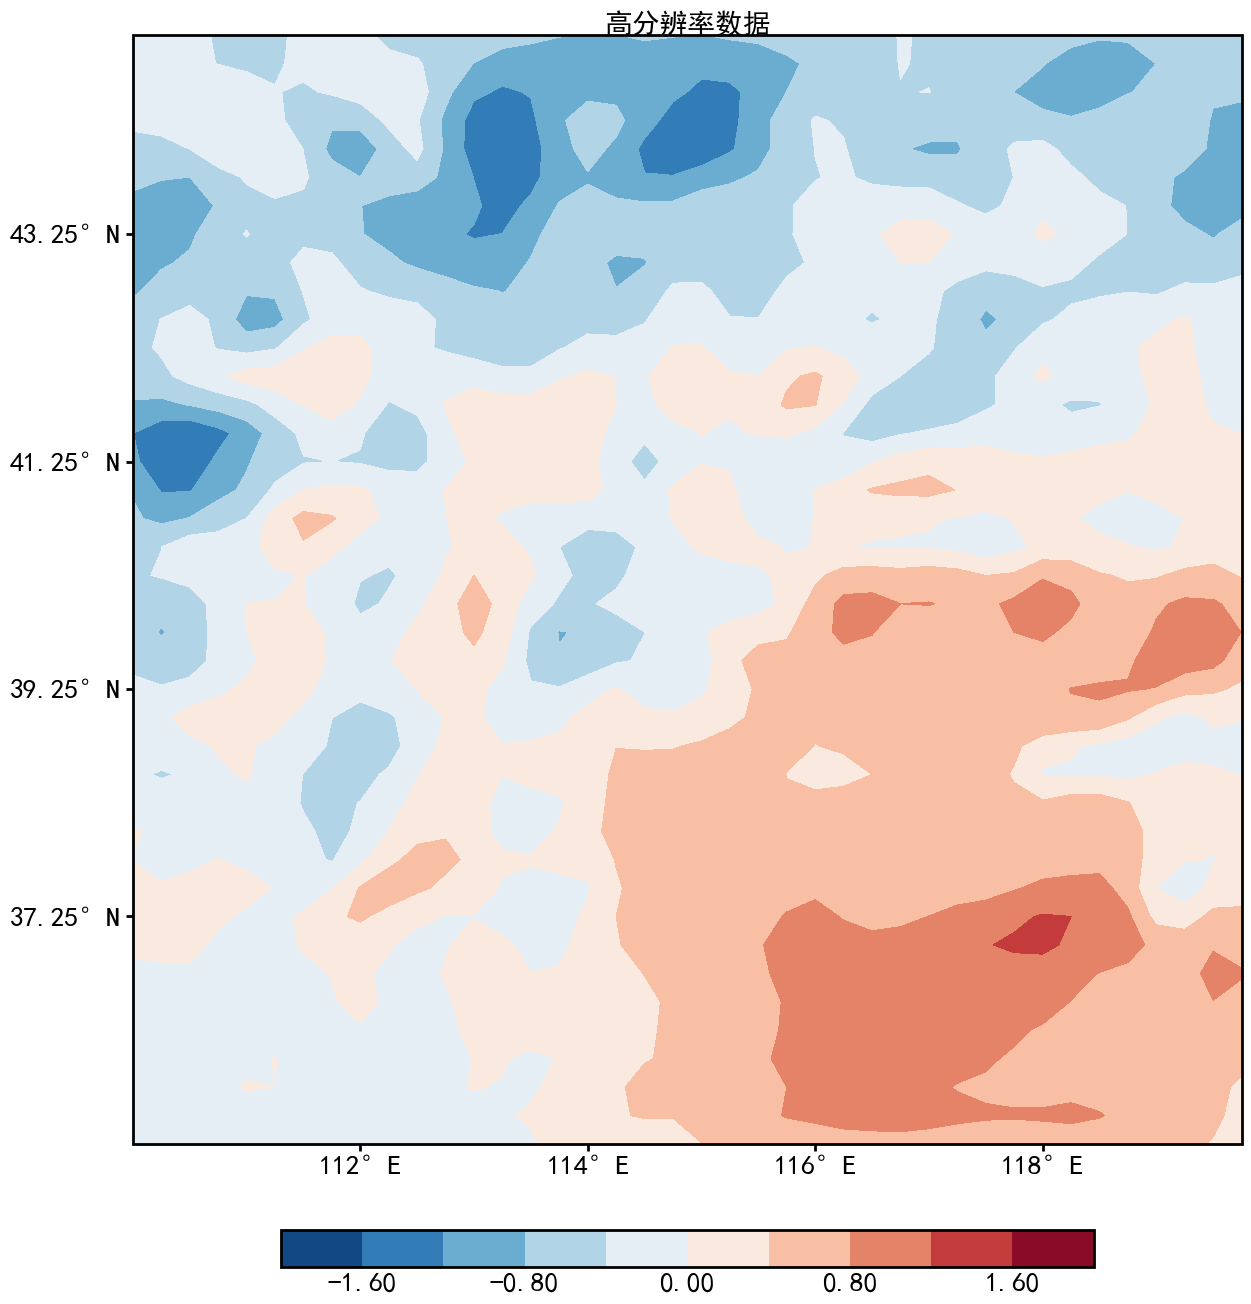

<Figure size 640x480 with 0 Axes>

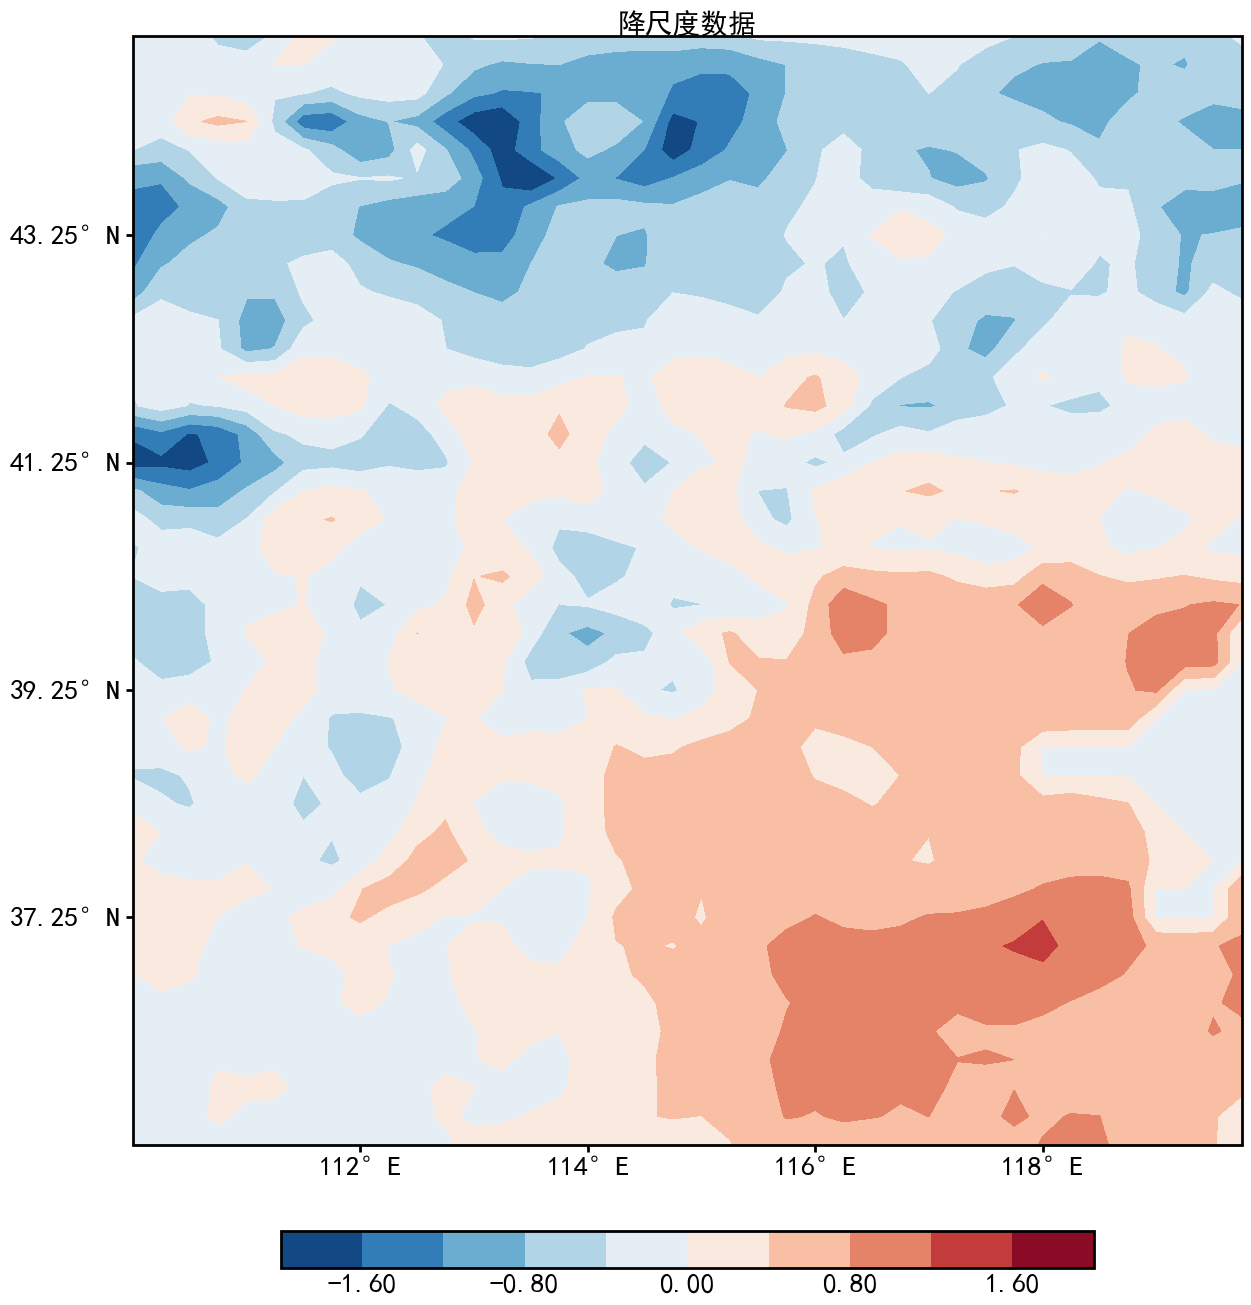

<Figure size 640x480 with 0 Axes>

In [5]:
import Auto_paint_self
Auto_paint_self.Autoshaded_quiver(testy[0,:,:],None,None,None,lon,lat,None,None,latlow,lattop,lonleft,lonright,'shaded','xy',picturenum=1,row=1,column=1,dpi=600,shadedcolor=None,ifshp='no',shpname=None,ifsave='no',savename=None,valuemodel='+-',ifself_vmax_vmin='yes',selfvmax =2.0,selfvmin=-2.0,shaded_quiver_title='高分辨率数据',ifline='no',ifclabel='no',ifcolorbar='yes',ifhatch='no',hatchpoint=None,hatchvalue=None,quiverscale=1,xspace=2,yspace=2,zspace=10000,labelsize=20,section=10.0,ifmaskout='no',maskoutarea=None,iftangle='no',tangle=None,ifchina='no',chinamap=None,ifsouthseamap='no',southseamap=None,southsealoc=[0.8, 0.21, 0.1, 0.15],ifglobal='no',projection_mode='plate',ifgridline='no',ifgeo='no',geo=None)
Auto_paint_self.Autoshaded_quiver(predicty[0,:,:],None,None,None,lon,lat,None,None,latlow,lattop,lonleft,lonright,'shaded','xy',picturenum=1,row=1,column=1,dpi=600,shadedcolor=None,ifshp='no',shpname=None,ifsave='no',savename=None,valuemodel='+-',ifself_vmax_vmin='yes',selfvmax =2.0,selfvmin=-2.0,shaded_quiver_title='降尺度数据',ifline='no',ifclabel='no',ifcolorbar='yes',ifhatch='no',hatchpoint=None,hatchvalue=None,quiverscale=1,xspace=2,yspace=2,zspace=10000,labelsize=20,section=10.0,ifmaskout='no',maskoutarea=None,iftangle='no',tangle=None,ifchina='no',chinamap=None,ifsouthseamap='no',southseamap=None,southsealoc=[0.8, 0.21, 0.1, 0.15],ifglobal='no',projection_mode='plate',ifgridline='no',ifgeo='no',geo=None)